# bistro (bayesian inference simplification for regression of treatment on outcome)

### Version 1.1 (Python versions > 3.8)
D. M. Burt


### TODO
1. Put ```plot_effects``` into class body.  
2. Genericize ```plot_effects```:  
    a. add a model type to specify difference-in-difference  
    b. pass TREAT and POST as variables (rather than leaving them hardcoded as TREAT and POST)  
3. Split data passed to fit into ```data_treat``` and ```data_control```.
    a. Implement getters and setters for ```self.data_treat``` and ```self.data_control```.
    b. ```self.data_control``` will be set/reset by matching function.
4. Add propensity score estimation and matching  
    a. nearest neighbor, caliper  
5. 

In [1]:
!pip install pymc==4.4

!pip install bambi patsy seaborn graphviz watermark

^C
   ---------------------------------------- 0.0/590.2 kB ? eta -:--:--
   ---------------------------------------- 590.2/590.2 kB 7.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 1.4/1.4 MB 10.4 MB/s eta 0:00:00
  Attempting uninstall: pymc
    Found existing installation: pymc 5.19.1
    Uninstalling pymc-5.19.1:
      Successfully uninstalled pymc-5.19.1


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bambi 0.15.0 requires pymc>=5.18.0, but you have pymc 4.4.0 which is incompatible.
pymc-extras 0.2.0 requires pymc>=5.19.1, but you have pymc 4.4.0 which is incompatible.


In [55]:
# activate a python 3.11 virtual environment: source python3.11/bin/activate
# pip install pymc==4.4 (at the moment, v5 is not working)
# remove aesara (pymc started using pytensor, and recently there are ambiguity warnings coming from having both installed)
# pip install bambi patsy seaborn graphviz

# data libraries
import pandas as pd
import numpy as np
import patsy as pt
import xarray as xr
from scipy import stats

# stats libraries
#import pymc3 as pm 
import pymc as pm
import bambi as bmb
import arviz as az

# control group matching libraries
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression

# viz libraries
# Note: graphviz will require additional binaries to be installed
import graphviz
import seaborn as sns
from tabulate import tabulate
from matplotlib import pyplot as plt
from matplotlib import rc

'''
# Linux font setup
rc('font',**{'family':'sans-serif',
             'sans-serif':['Helvetica', 'Roboto-Regular', 'Roboto', 'roboto', 'roboto-regular'],
             'size':10
            }
  )
'''


# Windows font setup
rc('font',**{'family':'sans-serif',
             'sans-serif':['Aptos', 'Arial'],
             'size':10
            }
  )


import watermark

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
import pandas as pd
import xarray as xr
import numpy as np
import patsy as pt
import bambi as bmb
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import NearestNeighbors
from typing import Union, List, Tuple, Optional

# ------------------------------------------------------------------------------
# Custom Exception
# ------------------------------------------------------------------------------
class BistroError(Exception):
    """Custom exception for Bistro-related errors."""
    pass

# ------------------------------------------------------------------------------
# Data Handling
# ------------------------------------------------------------------------------
class DataHandler:
    """
    Handles conversion and validation of treatment and control data.
    Internally, data is stored as a pandas DataFrame.
    """
    def __init__(self, 
                 data_treat: Union[pd.DataFrame, xr.Dataset], 
                 data_control: Union[pd.DataFrame, xr.Dataset], 
                 treat_var: str) -> None:
        if not treat_var:
            raise BistroError("The 'treat_var' parameter must be specified.")
        self.treat_var = treat_var
        self.data_treat = self._convert_to_dataframe(data_treat, 'data_treat')
        self.data_control = self._convert_to_dataframe(data_control, 'data_control')
        self._validate_columns()
        self.data_combined = self._combine_data()

    def _convert_to_dataframe(self, data, name: str) -> pd.DataFrame:
        """Converts xarray Dataset or pandas DataFrame to a pandas DataFrame."""
        if isinstance(data, pd.DataFrame):
            return data.copy(deep=True)
        elif isinstance(data, xr.Dataset):
            # Resetting index so that the data is in tabular form
            return data.to_dataframe().reset_index()
        else:
            raise BistroError(f"{name} must be a pandas DataFrame or an xarray Dataset.")

    def _validate_columns(self) -> None:
        """
        Ensures that both treatment and control datasets have matching columns
        (except for the treatment indicator).
        """
        # For treatment, if treat_var is missing, assume treated (1)
        if self.treat_var not in self.data_treat.columns:
            self.data_treat[self.treat_var] = 1
        # For control, if treat_var is missing, assume control (0)
        if self.treat_var not in self.data_control.columns:
            self.data_control[self.treat_var] = 0

        # Check that non-treatment columns match
        treat_cols = set(self.data_treat.columns) - {self.treat_var}
        control_cols = set(self.data_control.columns) - {self.treat_var}
        if treat_cols != control_cols:
            raise BistroError("data_treat and data_control have different non-treatment variables.")

    def _combine_data(self) -> pd.DataFrame:
        """Combines treatment and control data into a single DataFrame."""
        return pd.concat([self.data_treat, self.data_control], ignore_index=True)

# ------------------------------------------------------------------------------
# Modeling
# ------------------------------------------------------------------------------
class BaseModel:
    """Abstract base class for regression models."""
    def fit(self):
        raise NotImplementedError("Subclasses must implement this method.")

class DiDModel(BaseModel):
    """
    Difference-in-Differences model that uses a patsy-style formula.
    Uses Bambi for Bayesian model fitting.
    """
    def __init__(self, formula: str, data: pd.DataFrame):
        self.formula = formula
        self.data = data
        self.fitted_model = None

    def fit(self):
        self.fitted_model = bmb.Model(self.formula, self.data).fit()
        return self.fitted_model

# ------------------------------------------------------------------------------
# Visualization
# ------------------------------------------------------------------------------
class Visualizer:
    """Collection of static methods for generating high-quality plots."""
    
    @staticmethod
    def plot_trace(fitted_model, show: bool = True):
        """Plots a trace plot for the fitted model using ArviZ."""
        fig = az.plot_trace(fitted_model)
        plt.tight_layout()
        sns.despine()
        if show:
            plt.show()
        return fig

    @staticmethod
    def plot_hdi_density(fitted_model, 
                         data: Optional[pd.DataFrame] = None, 
                         interval: float = 0.89, 
                         figsize: Optional[Tuple[int, int]] = None, 
                         show: bool = True):
        """
        Plots a kernel density estimate for each parameter with the specified HDI.
        If no data is provided, extracts the posterior from the fitted model.
        """
        if data is None:
            data = fitted_model.posterior.to_dataframe()
        list_params = list(data.columns)
        n_params = len(list_params)
        n_rows = int(np.floor(np.sqrt(n_params)))
        n_cols = int(np.ceil(n_params / n_rows))
        if figsize is None:
            figsize = (n_cols * 3, n_rows * 3)
        caption_zero = 'x=0 shown in red if it exists in the HDI.'
        fig, ax = plt.subplots(n_rows, n_cols, figsize=figsize)
        fig.suptitle(f'Density of Parameter Estimates ({int(interval * 100)}% HDI)')
        fig.text(0.5, 0.935, caption_zero, ha='center', size=8, color='firebrick')
        
        # Ensure ax is a 2D array for consistent indexing
        ax = np.atleast_2d(ax)
        plot_index = 0
        for i in range(n_rows):
            for j in range(n_cols):
                ax[i, j].set_axis_off()
                if plot_index < n_params:
                    ax[i, j].set_axis_on()
                    # Sample data for KDE smoothing
                    col_data = data.iloc[:, plot_index]
                    data_sample = col_data.sample(min(len(col_data), 1000), replace=False)
                    hdi_lo = np.quantile(data_sample, (1 - interval) / 2)
                    hdi_hi = np.quantile(data_sample, 1 - (1 - interval) / 2)
                    hdi_median = np.median(data_sample)
                    hdi_range = hdi_hi - hdi_lo
                    sns.kdeplot(data_sample, clip=(hdi_lo, hdi_hi), color='#333', fill='#777', alpha=0.6, ax=ax[i, j])
                    ax[i, j].set_title(f'{list_params[plot_index]}', size=10)
                    ax[i, j].set_xlim(hdi_lo - 0.2 * hdi_range, hdi_hi + 0.2 * hdi_range)
                    ax[i, j].xaxis.set_tick_params(labelsize=8)
                    ax[i, j].yaxis.set_tick_params(labelsize=8)
                    if hdi_lo < 0 and hdi_hi > 0:
                        ax[i, j].axvline(0, color='firebrick', alpha=0.2, linestyle='--')
                    ax[i, j].axvline(hdi_median, color='#fff', linestyle=':')
                    ax[i, j].annotate(f'median:\n{np.round(hdi_median, 3)}', 
                                      xy=(hdi_median + hdi_range * 0.02, ax[i, j].get_ylim()[1] * 0.02), 
                                      color='w', size=8)
                    ax[i, j].axvline(hdi_lo, color='#777', linestyle=':')
                    ax[i, j].annotate(f'{(1 - interval) / 2 * 100:.1f}%:\n{np.round(hdi_lo, 3)}', 
                                      xy=(hdi_lo + hdi_range * 0.02, ax[i, j].get_ylim()[1] * 0.9), 
                                      color='#222', size=8)
                    ax[i, j].axvline(hdi_hi, color='#777', linestyle=':')
                    ax[i, j].annotate(f'{(1 - (1 - interval) / 2) * 100:.1f}%:\n{np.round(hdi_hi, 3)}', 
                                      xy=(hdi_hi + hdi_range * 0.02, ax[i, j].get_ylim()[1] * 0.9), 
                                      color='#222', size=8)
                plot_index += 1
        plt.tight_layout()
        sns.despine()
        if show:
            plt.show()
        return fig

    @staticmethod
    def label_line(ax, line, label: str, x_pos: float, label_fontsize: int, y_pad: float,
                   split_point: float = 0, above_line: bool = True, angle_deg: Optional[float] = None, 
                   color: Optional[str] = None):
        """
        Labels a line on a plot. Calculates the rotation based on the line's slope.
        """
        line_xydata = line.get_xydata()
        line_xydata = line_xydata[line_xydata[:, 0] >= split_point]
        y_lim = ax.get_ylim()
        intercept = line_xydata[0][1]
        rise = line_xydata[-1][1] - intercept
        run = line_xydata[-1][0] - split_point
        y_pos = intercept + x_pos * (rise * run)
        if angle_deg is None:
            angle_deg = np.degrees(np.arctan2(rise, run))
        if y_pad is None:
            y_pad = 0.02 * (y_lim[1] - y_lim[0])
        if color is None:
            color = line.get_color()
        ax.text(x=x_pos, 
                y=y_pos + (1 if above_line else -1.5) * y_pad, 
                s=label,
                size=label_fontsize,
                rotation=angle_deg, 
                rotation_mode='anchor',            
                transform_rotates_text=True,
                color=color)

    @staticmethod
    def plot_effects(fitted_model, 
                     line_type: str = 'single', 
                     show_intervals: bool = True, 
                     split_point: float = 0,
                     n_lines: int = 10,
                     figsize: Tuple[int, int] = (9, 3),
                     hdi: float = 0.89,
                     plot_interval: bool = True,
                     show_did: bool = False,
                     title_fontsize: int = 12,
                     suptitle_fontsize: int = 14,
                     tick_fontsize: int = 8,
                     label_fontsize: int = 10,
                     control_color: str = '#333333',
                     treat_factual_color: str = '#1295D8',
                     treat_counterfactual_color: str = '#005581',
                     y_label: str = 'Y',
                     y_pad: Tuple[float, float, float] = (0.02, 0.02, 0.02),
                     labels_above_line: Tuple[bool, bool, bool] = (True, True, True),
                     show: bool = True):
        """
        Plots difference-in-differences effects. The left panel shows the regression lines
        for control, factual treatment, and counterfactual treatment. The right panel displays
        the density of the interaction parameter (i.e., the DiD effect).
        """
        posterior = fitted_model.posterior.to_dataframe()
        temp_intercept = posterior['Intercept'].to_numpy().ravel()
        temp_treat = posterior['TREAT'].to_numpy().ravel()
        temp_post = posterior['POST'].to_numpy().ravel()
        temp_interact = posterior['TREAT:POST'].to_numpy().ravel()

        interval = (1 - hdi)
        interval_point_lo = interval / 2
        interval_point_hi = 1 - interval / 2

        if line_type == 'single':
            plt_intercept = np.array([np.quantile(temp_intercept, 0.5)])
            plt_treat = np.array([np.quantile(temp_treat, 0.5)])
            plt_post = np.array([np.quantile(temp_post, 0.5)])
            plt_interact = np.array([np.quantile(temp_interact, 0.5)])
            n_lines = 1
            line_alpha = 1

            hdi_lo_intercept = np.array([np.quantile(temp_intercept, interval_point_lo)])
            hdi_hi_intercept = np.array([np.quantile(temp_intercept, interval_point_hi)])
            hdi_lo_treat = np.array([np.quantile(temp_treat, interval_point_lo)])
            hdi_hi_treat = np.array([np.quantile(temp_treat, interval_point_hi)])
            hdi_lo_post = np.array([np.quantile(temp_post, interval_point_lo)])
            hdi_hi_post = np.array([np.quantile(temp_post, interval_point_hi)])
            hdi_lo_interact = np.array([np.quantile(temp_interact, interval_point_lo)])
            hdi_hi_interact = np.array([np.quantile(temp_interact, interval_point_hi)])
        elif line_type == 'multi':
            plt_intercept = temp_intercept
            plt_treat = temp_treat
            plt_post = temp_post
            plt_interact = temp_interact
            line_alpha = 0.1
            plot_interval = None
        else:
            raise BistroError(f"plot_effects() line_type must be 'single' or 'multi'. Got {line_type}.")

        fig, ax = plt.subplots(1, 2, figsize=figsize)
        ylim_padding = 0.1
        ylim_lo = np.min([0, 
                          np.min(plt_intercept) * (1 + ylim_padding), 
                          np.min(plt_intercept + plt_treat) * (1 + ylim_padding),
                          np.min(plt_intercept + plt_post) * (1 + ylim_padding),
                          np.min(plt_intercept + plt_treat + plt_post) * (1 + ylim_padding),
                          np.min(plt_intercept + plt_treat + plt_post + plt_interact) * (1 + ylim_padding)
                         ])
        ylim_hi = np.max([np.max(plt_intercept) * (1 + ylim_padding), 
                          np.max(plt_intercept + plt_treat) * (1 + ylim_padding),
                          np.max(plt_intercept + plt_post) * (1 + ylim_padding),
                          np.max(plt_intercept + plt_treat + plt_post) * (1 + ylim_padding),
                          np.max(plt_intercept + plt_treat + plt_post + plt_interact) * (1 + ylim_padding)
                         ])
        ax[0].set_ylim(np.min([0, ylim_lo]), ylim_hi)

        for i in range(n_lines):
            x = np.array([0, split_point, 1])
            treat_y_counterfactual = np.array([
                plt_intercept[i] + plt_treat[i],
                plt_intercept[i] + plt_treat[i] + split_point * plt_post[i],
                plt_intercept[i] + plt_treat[i] + plt_post[i]
            ])
            treat_y_factual = np.array([
                plt_intercept[i] + plt_treat[i],
                plt_intercept[i] + plt_treat[i] + split_point * plt_post[i],
                plt_intercept[i] + plt_treat[i] + plt_post[i] + plt_interact[i]
            ])
            control_y = np.array([
                plt_intercept[i],
                plt_intercept[i] + split_point * plt_post[i],
                plt_intercept[i] + plt_post[i]
            ])
            did_y = np.array([
                plt_intercept[i] + plt_treat[i] + plt_post[i] + plt_interact[i],
                plt_intercept[i] + plt_treat[i] + plt_post[i]
            ])
            did_direction = -1 if did_y[0] < did_y[1] else 1

            line_treat_counterfactual, = ax[0].plot(x, 
                                                     treat_y_counterfactual, 
                                                     color=treat_counterfactual_color, 
                                                     linestyle='--', 
                                                     alpha=line_alpha)
            line_treat_factual, = ax[0].plot(x, 
                                            treat_y_factual, 
                                            color=treat_factual_color, 
                                            alpha=line_alpha)
            line_control, = ax[0].plot(x, 
                                        control_y, 
                                        color=control_color, 
                                        alpha=line_alpha)
            if show_did and i == 0:
                ax[0].arrow(1.02, did_y[1], dx=0, 
                            dy=did_direction * np.abs(did_y[0] - did_y[1]), 
                            length_includes_head=True,
                            head_width=0.01, head_length=0.2,
                            color='#FDB515')
                ax[0].annotate(f'DiD:\n{did_direction * np.abs(did_y[0] - did_y[1]):.3f}', 
                               xy=(1.03, np.min(did_y)), 
                               color='#c4820e', size=label_fontsize)
            ax[0].set_ylabel(y_label)
            if split_point != 0:
                ax[0].set_xticks([0, split_point, 1])
                ax[0].set_xticklabels(['PRE', 'Intervention', 'POST'], fontsize=tick_fontsize)
                ax[0].axvline(x=split_point, linestyle=':', color='#333', alpha=0.2)
            else:
                ax[0].set_xticks([0, 1])
                ax[0].set_xticklabels(['PRE', 'POST'], fontsize=tick_fontsize)
            
            if plot_interval:
                treat_y_factual_interval_hi = np.array([
                    hdi_hi_intercept[i] + hdi_hi_treat[i],
                    hdi_hi_intercept[i] + hdi_hi_treat[i] + split_point * hdi_hi_post[i],
                    hdi_hi_intercept[i] + hdi_hi_treat[i] + hdi_hi_post[i] + hdi_hi_interact[i]
                ])
                treat_y_factual_interval_lo = np.array([
                    hdi_lo_intercept[i] + hdi_lo_treat[i],
                    hdi_lo_intercept[i] + hdi_lo_treat[i] + split_point * hdi_lo_post[i],
                    hdi_lo_intercept[i] + hdi_lo_treat[i] + hdi_lo_post[i] + hdi_lo_interact[i]
                ])
                ax[0].plot(x, treat_y_factual_interval_hi, color=treat_factual_color, alpha=0.05)
                ax[0].plot(x, treat_y_factual_interval_lo, color=treat_factual_color, alpha=0.05)
                ax[0].fill_between(x, treat_y_factual_interval_hi, treat_y_factual_interval_lo, color=treat_factual_color, alpha=0.05)
                
                treat_y_counterfactual_interval_hi = np.array([
                    hdi_hi_intercept[i] + hdi_hi_treat[i],
                    hdi_hi_intercept[i] + hdi_hi_treat[i] + split_point * hdi_hi_post[i],
                    hdi_hi_intercept[i] + hdi_hi_treat[i] + hdi_hi_post[i]
                ])
                treat_y_counterfactual_interval_lo = np.array([
                    hdi_lo_intercept[i] + hdi_lo_treat[i],
                    hdi_lo_intercept[i] + hdi_lo_treat[i] + split_point * hdi_lo_post[i],
                    hdi_lo_intercept[i] + hdi_lo_treat[i] + hdi_lo_post[i]
                ])
                ax[0].plot(x, treat_y_counterfactual_interval_hi, color=treat_counterfactual_color, alpha=0.05)
                ax[0].plot(x, treat_y_counterfactual_interval_lo, color=treat_counterfactual_color, alpha=0.05)
                ax[0].fill_between(x, treat_y_counterfactual_interval_hi, treat_y_counterfactual_interval_lo, color=treat_counterfactual_color, alpha=0.05)
                
                control_y_interval_hi = np.array([
                    hdi_hi_intercept[i],
                    hdi_hi_intercept[i] + split_point * hdi_hi_post[i],
                    hdi_hi_intercept[i] + hdi_hi_post[i]
                ])
                control_y_interval_lo = np.array([
                    hdi_lo_intercept[i],
                    hdi_lo_intercept[i] + split_point * hdi_lo_post[i],
                    hdi_lo_intercept[i] + hdi_lo_post[i]
                ])
                ax[0].plot(x, control_y_interval_hi, color=control_color, alpha=0.1)
                ax[0].plot(x, control_y_interval_lo, color=control_color, alpha=0.1)
                ax[0].fill_between(x, control_y_interval_hi, control_y_interval_lo, color=control_color, alpha=0.1)
                y_lo = np.min([np.min(control_y_interval_lo), np.min(treat_y_factual_interval_lo), np.min(treat_y_counterfactual_interval_lo)]) * 1.1
                if y_lo > 0:
                    y_lo = 0
                ax[0].set_ylim(y_lo,
                               np.max([np.max(control_y_interval_hi), np.max(treat_y_factual_interval_hi), np.max(treat_y_counterfactual_interval_hi)]) * 1.1)
            
            if i == 0:
                Visualizer.label_line(ax[0], line_treat_counterfactual, 'Treat counterfactual', 
                                      x_pos=0.7, label_fontsize=label_fontsize, y_pad=y_pad[1], 
                                      split_point=split_point, above_line=labels_above_line[1])
                Visualizer.label_line(ax[0], line_treat_factual, 'Treat factual', 
                                      x_pos=0.7, label_fontsize=label_fontsize, y_pad=y_pad[0], 
                                      split_point=split_point, above_line=labels_above_line[0])
                Visualizer.label_line(ax[0], line_control, 'Control actual', 
                                      x_pos=0, label_fontsize=label_fontsize, y_pad=y_pad[2], 
                                      split_point=0, above_line=labels_above_line[2])

        did_hdi_lo = np.quantile(temp_interact, interval_point_lo)
        did_hdi_hi = np.quantile(temp_interact, interval_point_hi)
        did_hdi_median = np.quantile(temp_interact, 0.5)
        did_hdi_range = did_hdi_hi - did_hdi_lo

        sns.kdeplot(temp_interact, color='#FDB515', fill='#FDB515', alpha=0.1, ax=ax[1])
        sns.kdeplot(temp_interact, clip=(did_hdi_lo, did_hdi_hi), color='#C4820E', fill='#C4820E', alpha=0.6, ax=ax[1])
        ax[1].set_xlim(did_hdi_lo - 0.2 * did_hdi_range, did_hdi_hi + 0.2 * did_hdi_range)
        ax[1].xaxis.set_tick_params(labelsize=tick_fontsize)
        ax[1].yaxis.set_tick_params(labelsize=tick_fontsize)
        if did_hdi_lo < 0 and did_hdi_hi > 0:
            ax[1].axvline(0, color='#FFF', alpha=0.8, linestyle='--', linewidth=2)
        ax[1].axvline(did_hdi_median, color='#333', linestyle=':')
        ax[1].annotate(f'median:\n{np.round(did_hdi_median, 3)}', 
                       xy=(did_hdi_median + did_hdi_range * 0.02, ax[1].get_ylim()[1] * 0.02), 
                       color='#333', size=label_fontsize + 2)
        ax[1].axvline(did_hdi_lo, color='#777', linestyle=':')
        ax[1].annotate(f'{interval_point_lo * 100:.1f}%:\n{np.round(did_hdi_lo, 3)}', 
                       xy=(did_hdi_lo + did_hdi_range * 0.02, ax[1].get_ylim()[1] * 0.9), 
                       color='#222', size=label_fontsize + 2)
        ax[1].axvline(did_hdi_hi, color='#777', linestyle=':')
        ax[1].annotate(f'{interval_point_hi * 100:.1f}%:\n{np.round(did_hdi_hi, 3)}', 
                       xy=(did_hdi_hi + did_hdi_range * 0.02, ax[1].get_ylim()[1] * 0.9), 
                       color='#222', size=label_fontsize + 2)
        caption_zero = 'x=0 shown in white if it exists in the HDI.'
        ax[1].text(np.mean(ax[1].get_xlim()), ax[1].get_ylim()[1] * 0.98, caption_zero, ha='center', size=8, color='#333')

        fig.suptitle('Difference-in-Difference Effects', size=suptitle_fontsize)
        ax[0].set_title('Control Group versus Treated Group', size=title_fontsize)
        ax[1].set_title(f'DiD Highest-Density Interval ({hdi * 100}%)', size=title_fontsize)
        plt.tight_layout(pad=figsize[0] / 5)
        sns.despine()
        if show:
            plt.show()
        return fig

# ------------------------------------------------------------------------------
# Matching
# ------------------------------------------------------------------------------
class NearestNeighborMatcher:
    """
    Implements nearest-neighbor matching for control group selection using 
    a KD Tree. Uses minmax or standard scaling as needed.
    """
    def __init__(self, 
                 data_handler: DataHandler, 
                 match_features: List[str], 
                 neighbors: int = 1, 
                 scaling: Optional[str] = None):
        self.data_handler = data_handler
        self.match_features = match_features
        self.neighbors = neighbors
        self.scaling = scaling

    def match(self) -> Tuple[pd.DataFrame, pd.DataFrame]:
        treat_df = self.data_handler.data_treat.copy()
        control_df = self.data_handler.data_control.copy().sample(frac=1)  # random shuffle

        if self.scaling is not None:
            scaling_method = self.scaling.lower()
            if scaling_method not in ['minmax', 'standard']:
                raise BistroError(f"Scaling parameter must be 'minmax' or 'standard', got {self.scaling}.")
            if scaling_method == 'minmax':
                scaler = MinMaxScaler().fit(treat_df[self.match_features])
            else:
                scaler = StandardScaler().fit(treat_df[self.match_features])
            treat_scaled = scaler.transform(treat_df[self.match_features])
            control_scaled = scaler.transform(control_df[self.match_features])
        else:
            treat_scaled = treat_df[self.match_features].values
            control_scaled = control_df[self.match_features].values

        nbrs = NearestNeighbors(n_neighbors=self.neighbors)
        nbrs.fit(control_scaled)
        distances, indices = nbrs.kneighbors(treat_scaled)
        matched_control_df = control_df.iloc[indices.ravel()].reset_index(drop=True)
        combined_df = pd.concat([treat_df, matched_control_df], ignore_index=True)
        return matched_control_df, combined_df

# ------------------------------------------------------------------------------
# Bistro Facade Class
# ------------------------------------------------------------------------------
class Bistro:
    """
    Bistro is the main interface for users.
    Users supply treatment and control data (pandas DataFrame or xarray Dataset)
    along with the treatment indicator variable name.
    
    The class provides methods to:
      - Fit a Bayesian difference-in-differences model.
      - Plot diagnostic and effect plots.
      - Perform nearest-neighbor matching.
    """
    def __init__(self, 
                 data_treat: Union[pd.DataFrame, xr.Dataset], 
                 data_control: Union[pd.DataFrame, xr.Dataset], 
                 treat_var: str):
        self.version = '1.0.20221230'
        self.data_handler = DataHandler(data_treat, data_control, treat_var)
        self.fitted_model = None

    def fit_did(self, formula: str) -> DiDModel:
        """Fits a difference-in-differences model using the provided patsy-style formula."""
        model = DiDModel(formula, self.data_handler.data_combined)
        self.fitted_model = model.fit()
        return self.fitted_model

    def plot_trace(self, show: bool = True):
        """Convenience method to plot trace plots from the fitted model."""
        if self.fitted_model is None:
            raise BistroError("No fitted model found. Please run fit_did() first.")
        return Visualizer.plot_trace(self.fitted_model, show=show)

    def plot_hdi_density(self, show: bool = True, **kwargs):
        """Plots the highest-density interval (HDI) densities for the fitted model."""
        if self.fitted_model is None:
            raise BistroError("No fitted model found. Please run fit_did() first.")
        return Visualizer.plot_hdi_density(self.fitted_model, show=show, **kwargs)

    def plot_effects(self, **kwargs):
        """Plots the DiD effects as regression lines and a density plot of the interaction parameter."""
        if self.fitted_model is None:
            raise BistroError("No fitted model found. Please run fit_did() first.")
        return Visualizer.plot_effects(self.fitted_model, **kwargs)

    def match_control_nn(self, 
                         match_features: List[str], 
                         neighbors: int = 1, 
                         scaling: Optional[str] = None) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """
        Performs nearest-neighbor matching on the control data using the specified features.
        Updates the internal data (data_control and data_combined) with the matched controls.
        """
        matcher = NearestNeighborMatcher(self.data_handler, match_features, neighbors, scaling)
        matched_control, combined = matcher.match()
        self.data_handler.data_control = matched_control
        self.data_handler.data_combined = combined
        return matched_control, combined


## Testing: let's make some fake data!

In [14]:
# test data

def make_fake_data(treat_size=100, control_size=100, trend=0, 
                   intervention_effect=1, 
                   control_mean=10, control_sd=1, 
                   treat_mean=12, treat_sd=1,
                   noise_sd=1
                  ):
    '''
    make_fake_data
    --------------
    convenience function for demonstration/testing purposes
    '''
    
    noise_size = np.max([treat_size, control_size])
    
    data_treat_pre = np.asarray([np.ones(treat_size),   # Group=Treat
                                 np.zeros(treat_size),  # Period=Post
                                 np.random.binomial(n=1, p=0.4, size=treat_size), # Female
                                 np.random.gamma(4, 3, size=treat_size), # Risk Score
                                 np.random.poisson(3, size=treat_size),   # N ED Visits
                                 np.random.beta(12,8, size=treat_size)    # Compliance Rate
                                ]
                               )
    df_treat_pre = pd.DataFrame(data_treat_pre.T)
    df_treat_pre.columns = ['TREAT', 'POST', 'Female', 'Risk', 'ED', 'Compliance']

    data_control_pre = np.asarray([np.zeros(control_size),   # Group=Treat
                                   np.zeros(control_size),   # Period=Post
                                   np.random.binomial(n=1, p=0.5, size=control_size), # Female
                                   np.random.gamma(2, 3, size=control_size), # Risk Score
                                   np.random.poisson(1, size=control_size),   # N ED Visits
                                   np.random.beta(10,10, size=control_size)    # Compliance Rate
                                  ]
                                 )
    df_control_pre = pd.DataFrame(data_control_pre.T)
    df_control_pre.columns = ['TREAT', 'POST', 'Female', 'Risk', 'ED', 'Compliance']


    data_treat_post = np.asarray([np.ones(treat_size),   # Group=Treat
                                  np.ones(treat_size),   # Period=Post
                                  data_treat_pre[3],    # Female
                                  data_treat_pre[4],    # Risk Score
                                  np.random.poisson(1, size=treat_size),   # N ED Visits
                                  np.random.beta(15,10, size=treat_size)    # Compliance Rate
                                 ]
                                )
    df_treat_post = pd.DataFrame(data_treat_post.T)
    df_treat_post.columns = ['TREAT', 'POST', 'Female', 'Risk', 'ED', 'Compliance']

    data_control_post = np.asarray([np.zeros(control_size),   # Group=Treat
                                    np.ones(control_size),    # Period=Post
                                    data_control_pre[3],    # Female
                                    data_control_pre[4],    # Risk Score
                                    np.random.poisson(1, size=control_size),   # N ED Visits
                                    np.random.beta(12,15, size=control_size)    # Compliance Rate
                                   ]
                                  )
    df_control_post = pd.DataFrame(data_control_post.T)
    df_control_post.columns = ['TREAT', 'POST', 'Female', 'Risk', 'ED', 'Compliance']

    df = pd.concat([df_treat_pre, df_treat_post, df_control_pre, df_control_post], axis=0)
    
    return df


In [15]:
# =============================================================================
# Set Parameters and Generate Dummy Data
# =============================================================================
treat_size = 300
control_size = 400
data_trend = 0.8
intervention_effect = 0.95
control_mean = 5
control_sd = 5
treat_mean = 10
treat_sd = 0.5

# Generate a combined DataFrame
df = make_fake_data(treat_size, control_size, data_trend, intervention_effect, 
                    control_mean, control_sd, treat_mean, treat_sd)

# Split the combined data into treatment and control datasets based on 'TREAT'
df_treat = df[df['TREAT'] == 1].reset_index(drop=True)
df_control = df[df['TREAT'] == 0].reset_index(drop=True)

print("Treatment data shape:", df_treat.shape)
print("Control data shape:", df_control.shape)


Treatment data shape: (600, 6)
Control data shape: (800, 6)


In [16]:
df.head(10)

TREAT  POST  Female       Risk   ED  Compliance
0    1.0   0.0     1.0  20.861880  2.0    0.623727
1    1.0   0.0     0.0  20.185110  1.0    0.715865
2    1.0   0.0     1.0   9.612401  4.0    0.680065
3    1.0   0.0     1.0   8.391778  1.0    0.712059
4    1.0   0.0     0.0   3.332826  2.0    0.617592
5    1.0   0.0     0.0  19.675971  2.0    0.639936
6    1.0   0.0     1.0   5.592565  6.0    0.618816
7    1.0   0.0     1.0   3.311353  3.0    0.676305
8    1.0   0.0     1.0  16.291041  5.0    0.637721
9    1.0   0.0     1.0  11.470116  1.0    0.555395

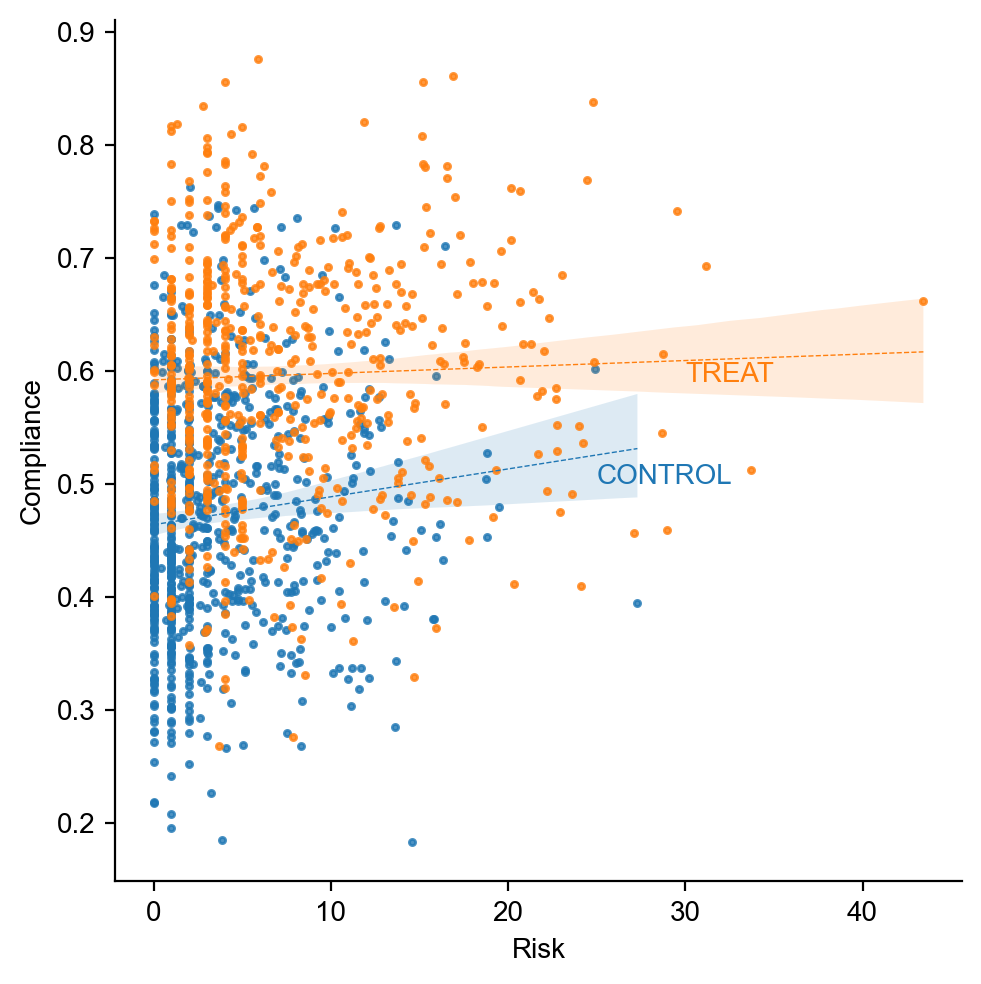

In [65]:
g = sns.lmplot(data=df, x='Risk', y='Compliance', hue='TREAT',
               scatter_kws={'s': 5}, line_kws={'linestyle':'--','linewidth':0.5},
               legend=False
              )
g.axes.flat[0].text(x=30, y=0.59,c='C1',s='TREAT')
g.axes.flat[0].text(x=25, y=0.5, c='C0',s='CONTROL')


sns.despine()
plt.tight_layout()
plt.show();

In [83]:
for i in g.axes.flat[0].lines:
    print(stats.linregress(i.get_xydata()))

LinregressResult(slope=0.0024679076233714878, intercept=0.46379252784739694, rvalue=0.9999999999999998, pvalue=0.0, stderr=5.2535270439120024e-12, intercept_stderr=8.300588621448774e-11)
LinregressResult(slope=0.0005710529622780967, intercept=0.591988523776853, rvalue=0.9999999999999991, pvalue=0.0, stderr=2.431243497465752e-12, intercept_stderr=6.112187501975514e-11)


C:\Users\dusti\AppData\Local\Temp\ipykernel_8740\445260733.py:2: DeprecationWarning: Inference of the two sets of measurements from a single "argument `x` is deprecated will result in an error in "SciPy 1.16.0; the sets must be specified separately as "`x` and `y`.
  print(stats.linregress(i.get_xydata()))


In [77]:
stats.linregress(t.get_xydata())

C:\Users\dusti\AppData\Local\Temp\ipykernel_8740\1606982831.py:1: DeprecationWarning: Inference of the two sets of measurements from a single "argument `x` is deprecated will result in an error in "SciPy 1.16.0; the sets must be specified separately as "`x` and `y`.
  stats.linregress(t.get_xydata())


LinregressResult(slope=0.0024679076233714878, intercept=0.46379252784739694, rvalue=0.9999999999999998, pvalue=0.0, stderr=5.2535270439120024e-12, intercept_stderr=8.300588621448774e-11)

Matched control shape: (600, 7)
Combined data shape after matching: (1200, 7)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, TREAT, POST, TREAT:POST]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


Fitted model summary:
Inference data with groups:
	> posterior
	> sample_stats
	> observed_data


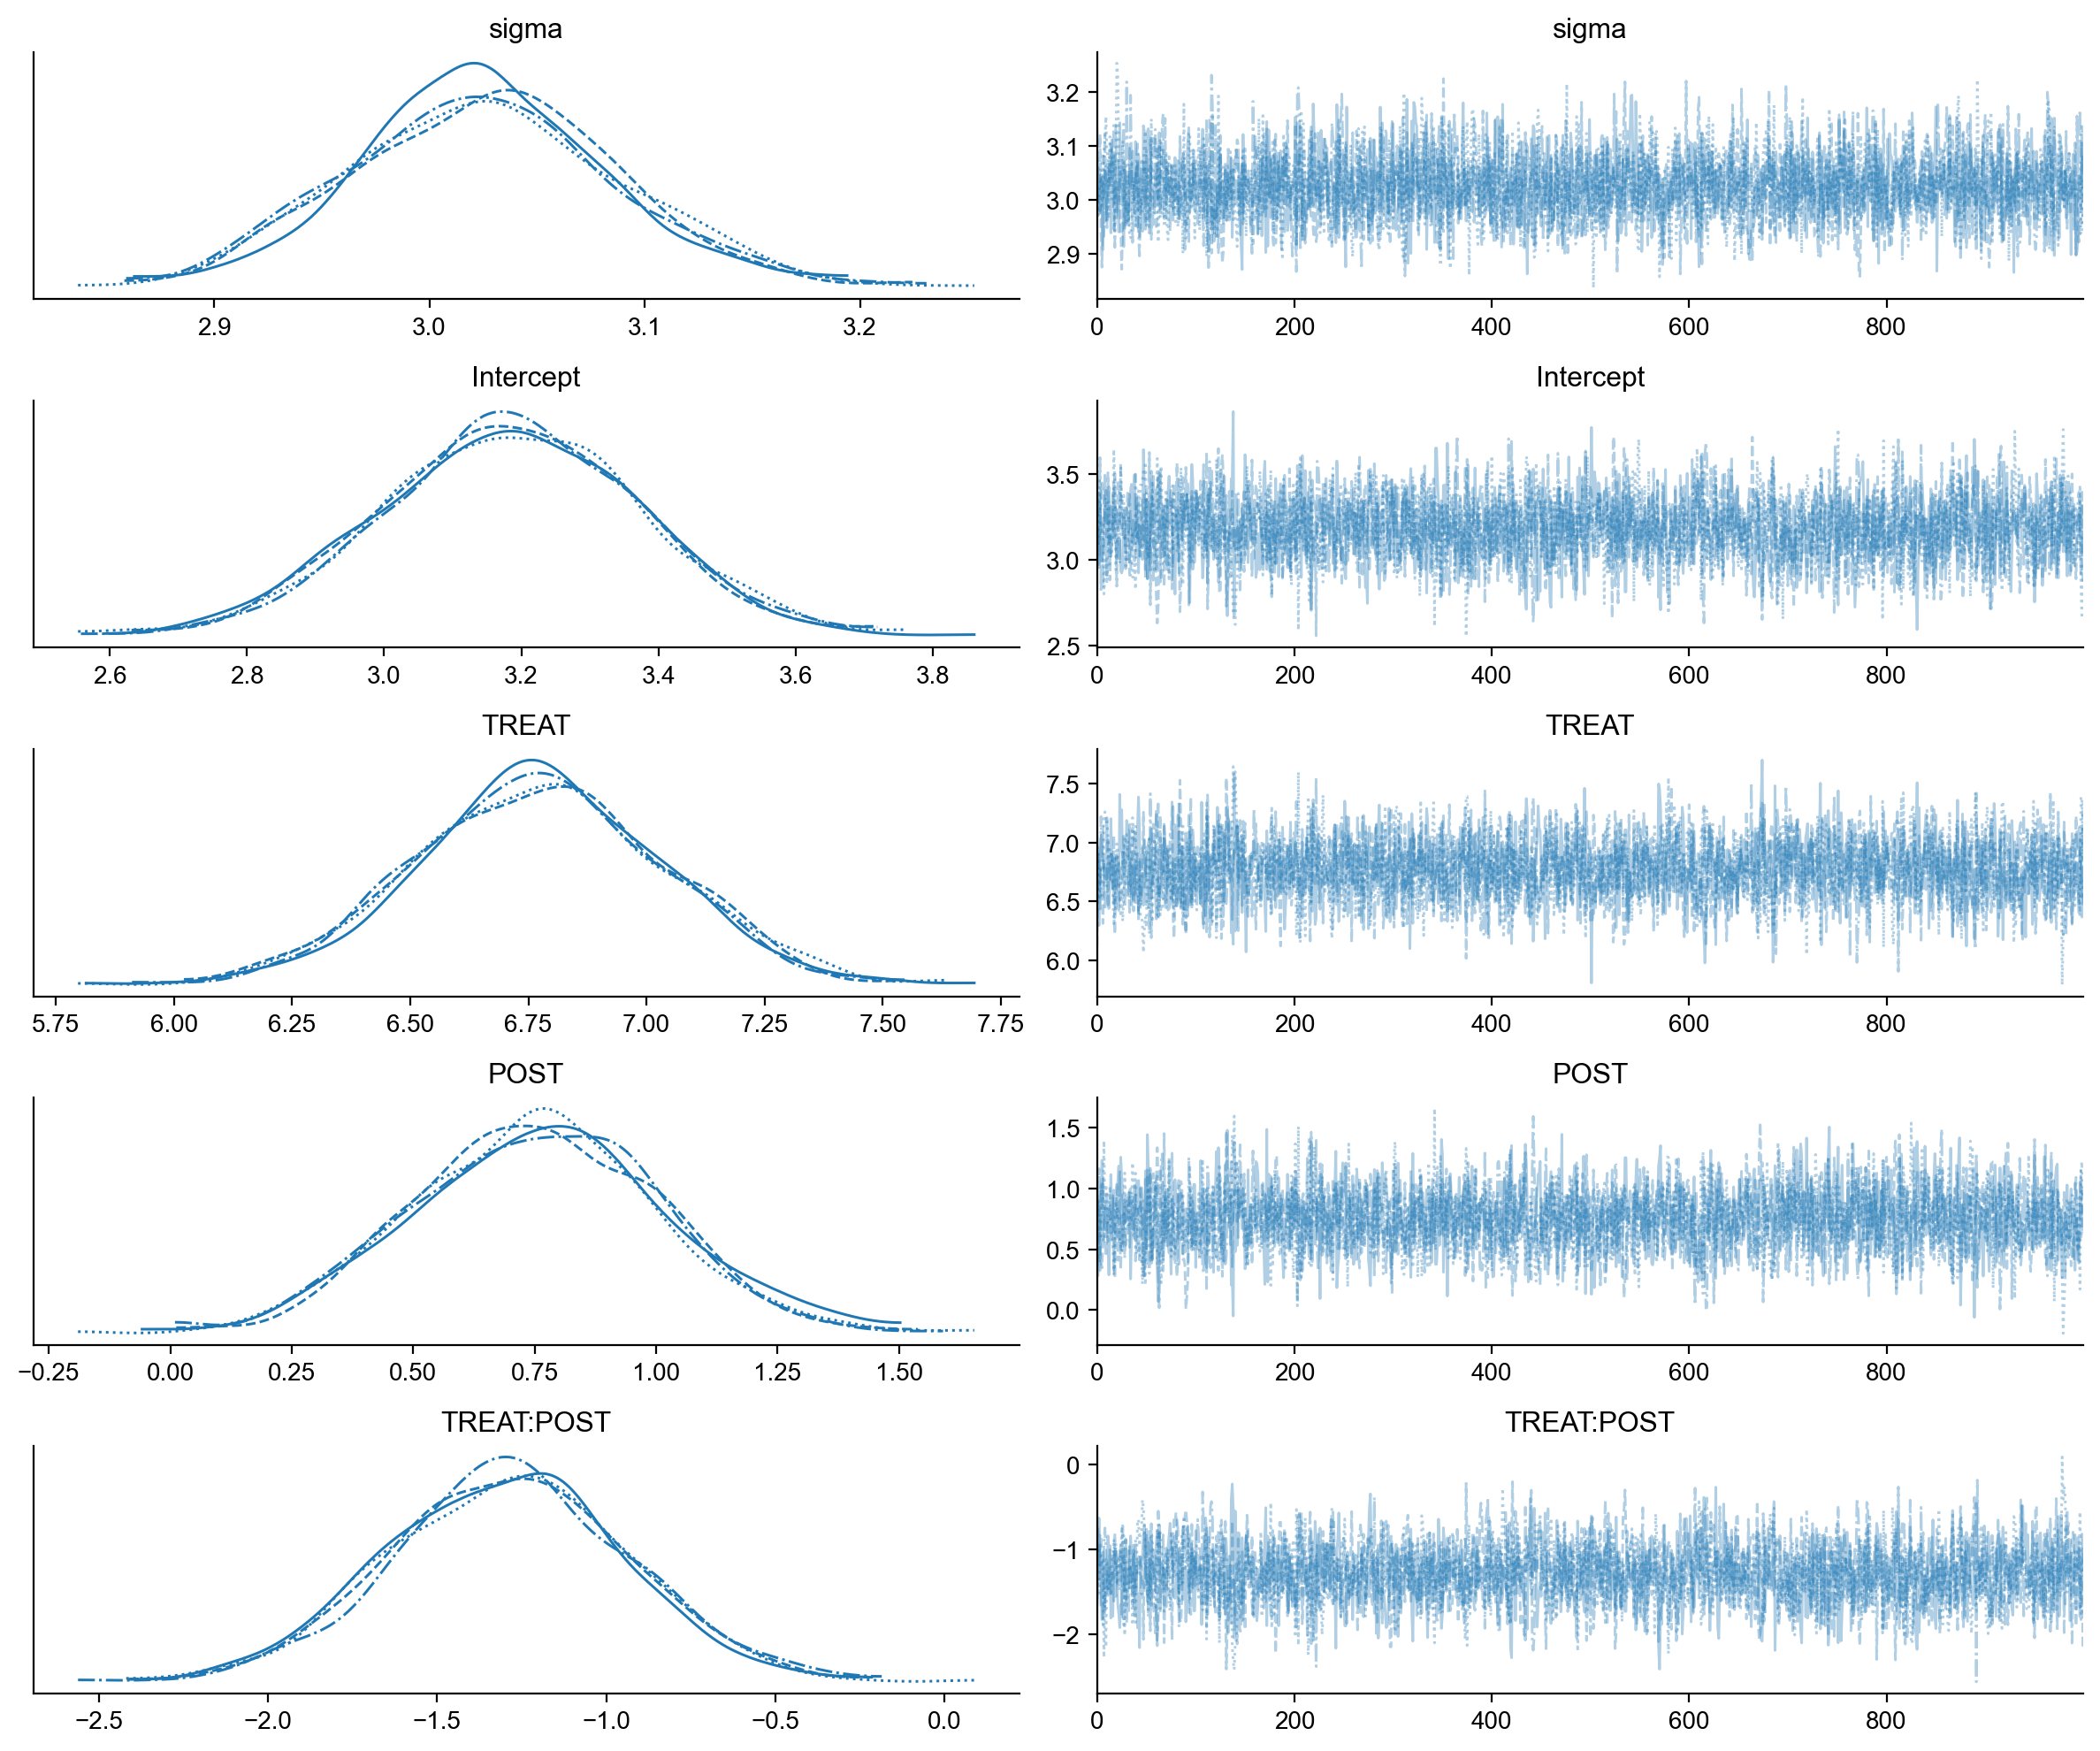

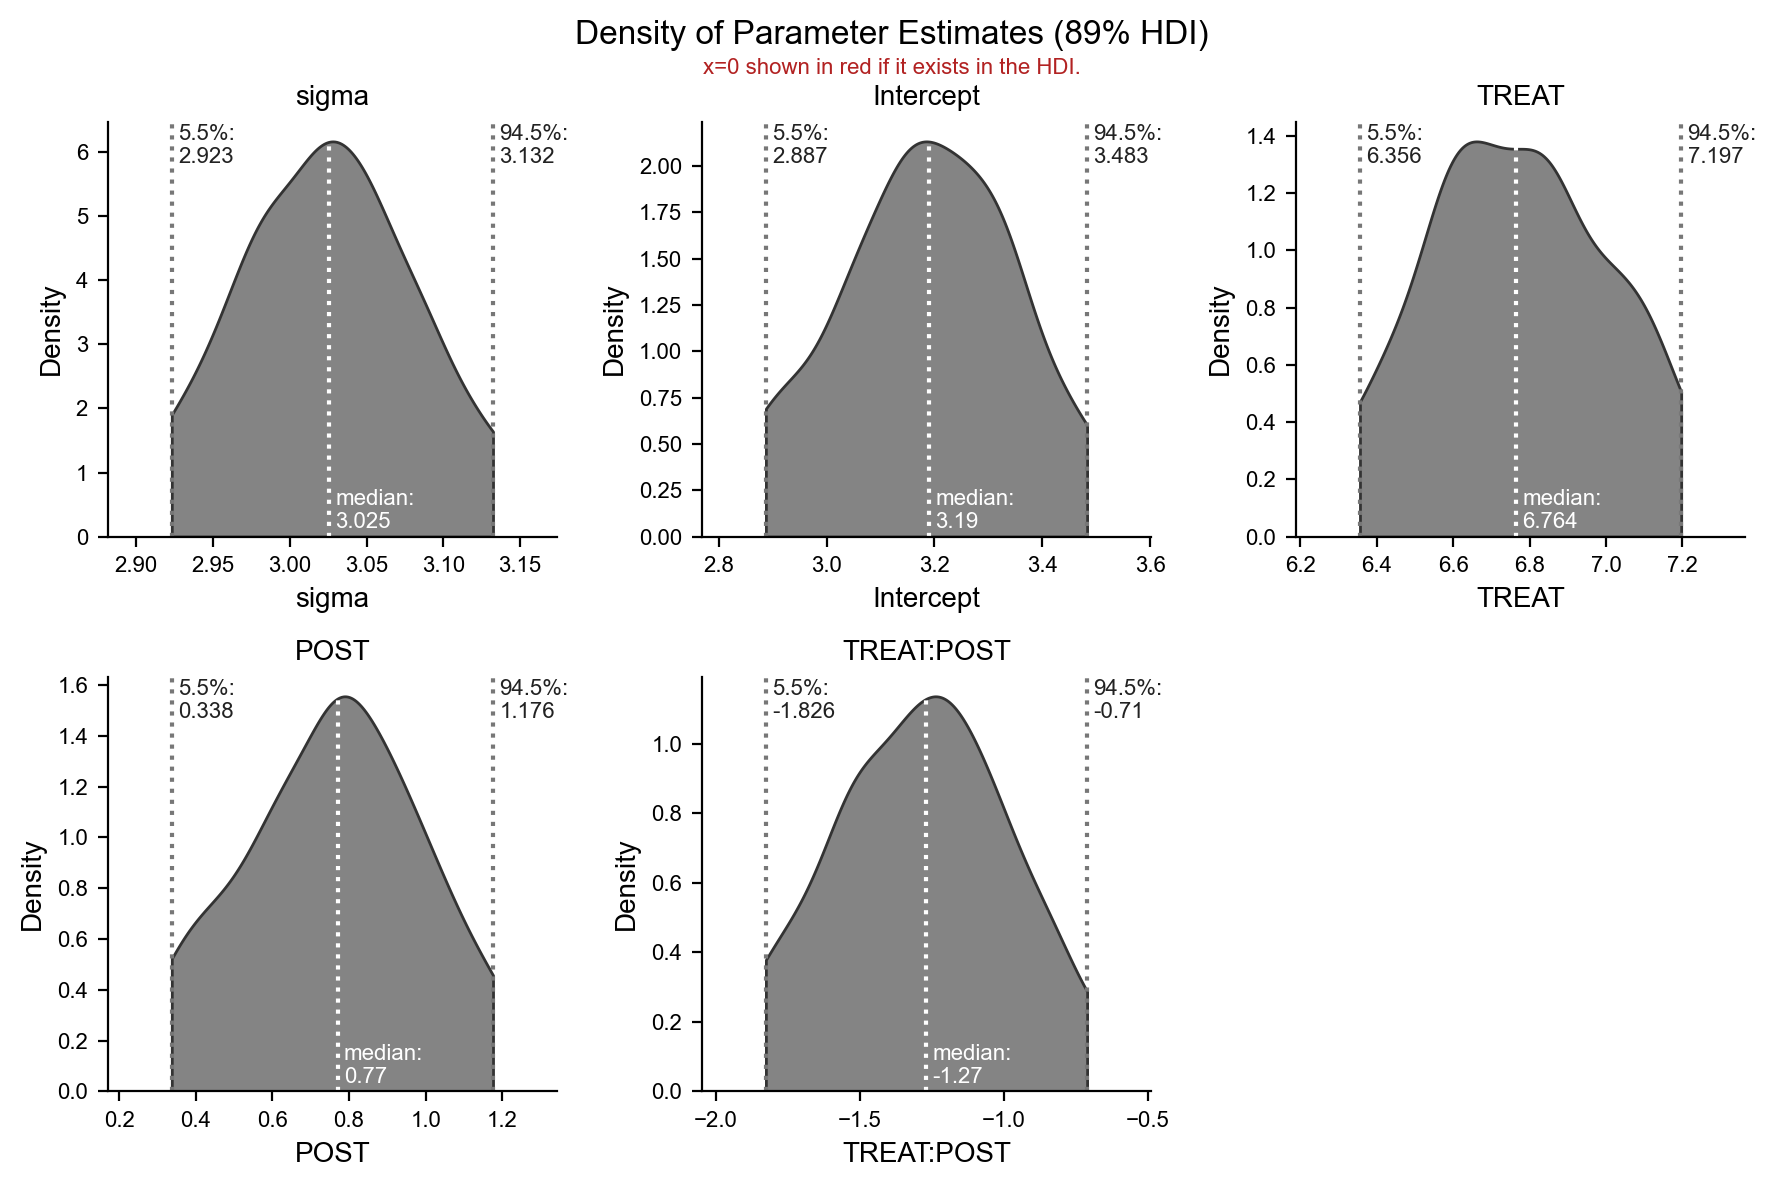

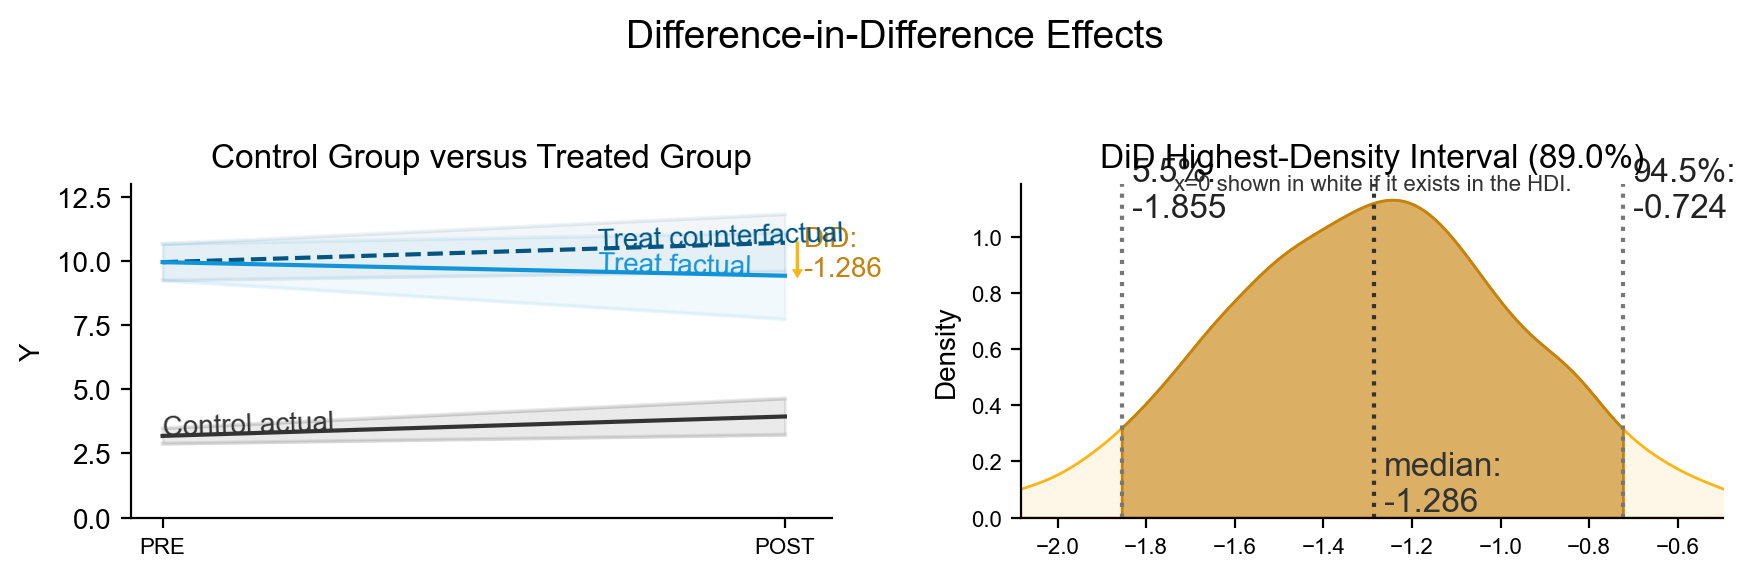

In [11]:

# =============================================================================
# Test the Bistro Codebase Functionality
# =============================================================================
# Import the refactored Bistro class (ensure your module path is correct)
# from bistro_module import Bistro  # Uncomment or adjust based on your module structure

# For demonstration, assume Bistro is available in the current scope:
bistro_instance = Bistro(data_treat=df_treat, data_control=df_control, treat_var='TREAT')

# --- Nearest-Neighbor Matching Test ---
# Use 'Risk' and 'ED' as matching features
matched_control, combined_data = bistro_instance.match_control_nn(
    match_features=['Risk'], 
    neighbors=1, 
    scaling='minmax'
)
print("Matched control shape:", matched_control.shape)
print("Combined data shape after matching:", combined_data.shape)

# --- Model Fitting Test ---
# Fit a difference-in-differences model.
# The formula assumes 'Y' as the outcome, and 'TREAT' and 'POST' as indicators with an interaction.
fitted_model = bistro_instance.fit_did(formula="Y ~ TREAT + POST + TREAT:POST")
print("Fitted model summary:")
print(fitted_model)

# --- Plotting Tests ---
# Display trace plot
bistro_instance.plot_trace()

# Display HDI density plots
bistro_instance.plot_hdi_density()

# Display DiD effects plots
bistro_instance.plot_effects(line_type='single', show_did=True)

# Ensure plots are rendered
plt.show()

### Run DiD on whole dataset

In [5]:
model = BModel(data_treat   = df.loc[df['TREAT']==1], 
               data_control = df.loc[df['TREAT']==0],
               treat_var = 'TREAT'
              )
model.fit(reg_formula = 'Y ~ TREAT + POST + TREAT * POST')

model = 

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, TREAT, POST, TREAT:POST]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


In [6]:
az.summary(model.fitted_model)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
sigma       3.550  0.069   3.425    3.684      0.001    0.001    3801.0   
Intercept   5.072  0.179   4.750    5.420      0.003    0.002    3228.0   
TREAT       4.933  0.278   4.428    5.470      0.005    0.003    3300.0   
POST       -1.055  0.253  -1.499   -0.572      0.004    0.003    3197.0   
TREAT:POST  0.514  0.388  -0.162    1.294      0.007    0.005    2783.0   

            ess_tail  r_hat  
sigma         3037.0    1.0  
Intercept     3213.0    1.0  
TREAT         3077.0    1.0  
POST          3023.0    1.0  
TREAT:POST    2635.0    1.0

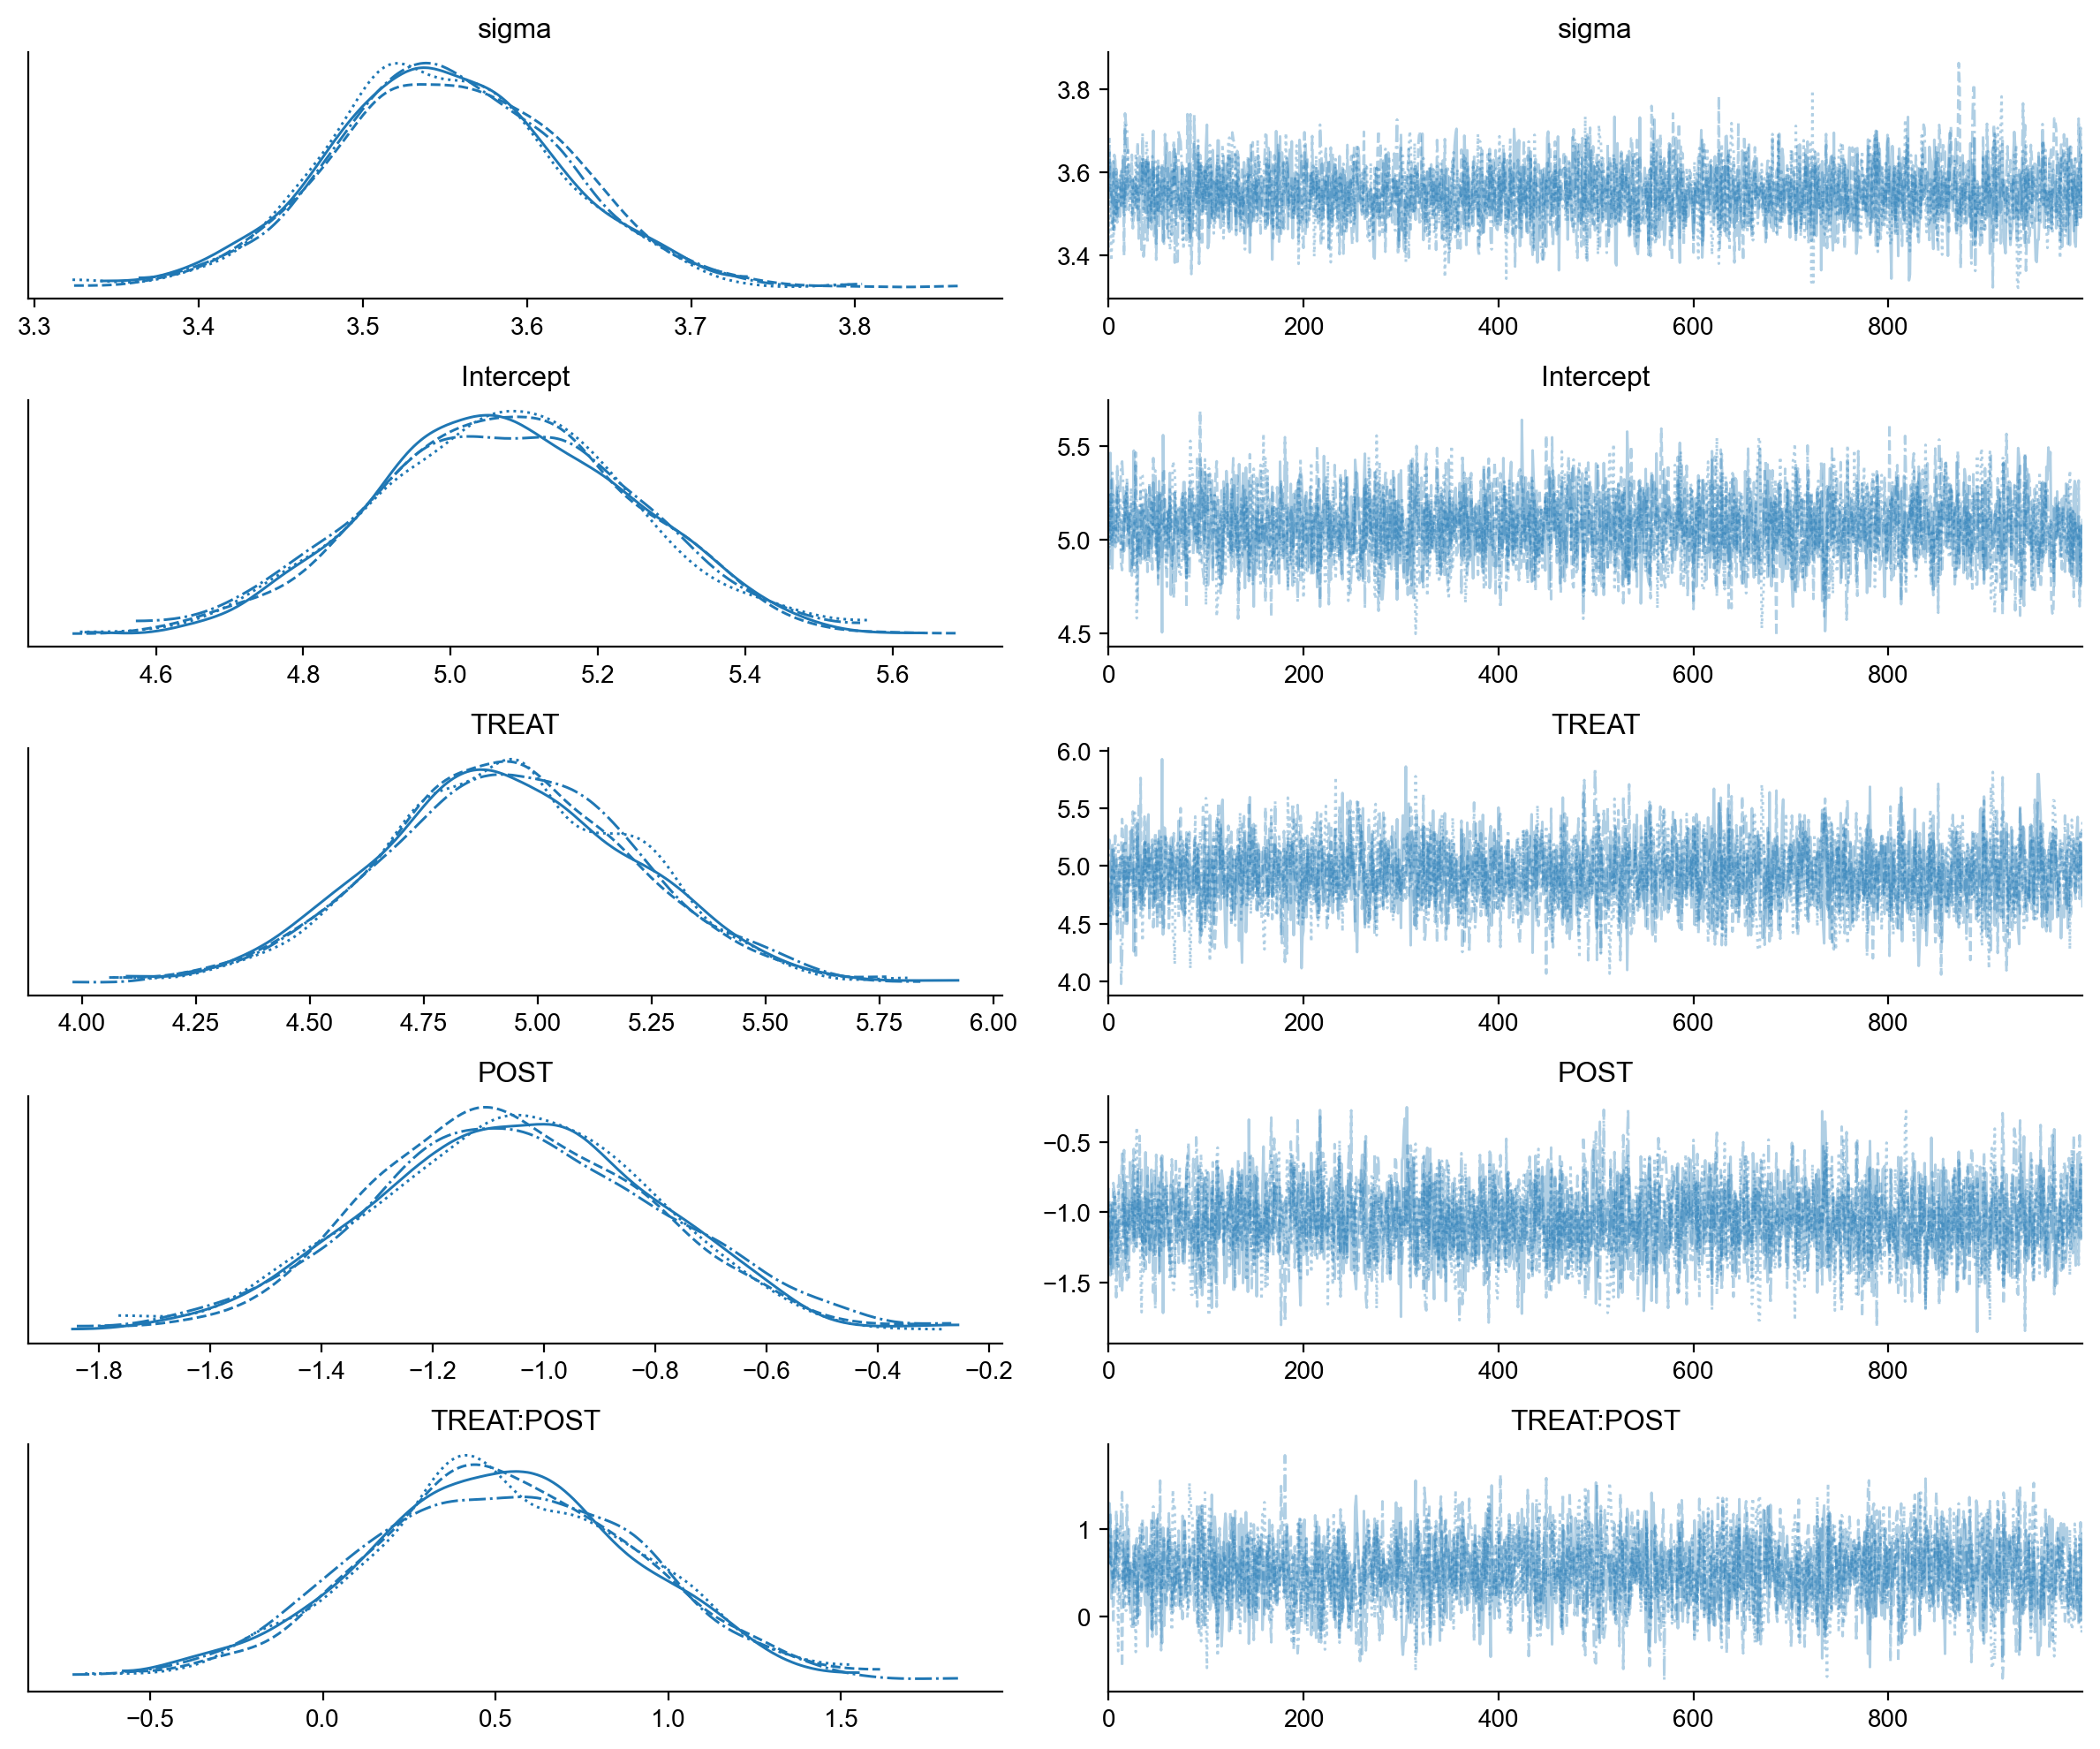

In [7]:
model.plot_trace()
plt.tight_layout()
sns.despine();

In [8]:
model.fitted_model['posterior']['TREAT:POST']

<xarray.DataArray 'TREAT:POST' (chain: 4, draw: 1000)> Size: 32kB
array([[ 0.62148778,  1.29367553,  1.06666727, ..., -0.0114142 ,
        -0.03251931,  0.94383749],
       [ 1.09301771,  0.67054694,  0.6083993 , ...,  0.10894007,
        -0.18609981, -0.10821464],
       [ 0.6797156 ,  1.00445291,  1.16233421, ...,  0.01246383,
         0.65163775,  0.83105762],
       [ 0.65485479,  0.7170835 ,  0.59817091, ...,  1.07583913,
         0.32846897,  0.1637303 ]])
Coordinates:
  * chain    (chain) int32 16B 0 1 2 3
  * draw     (draw) int32 4kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999

<Figure size 640x480 with 0 Axes>

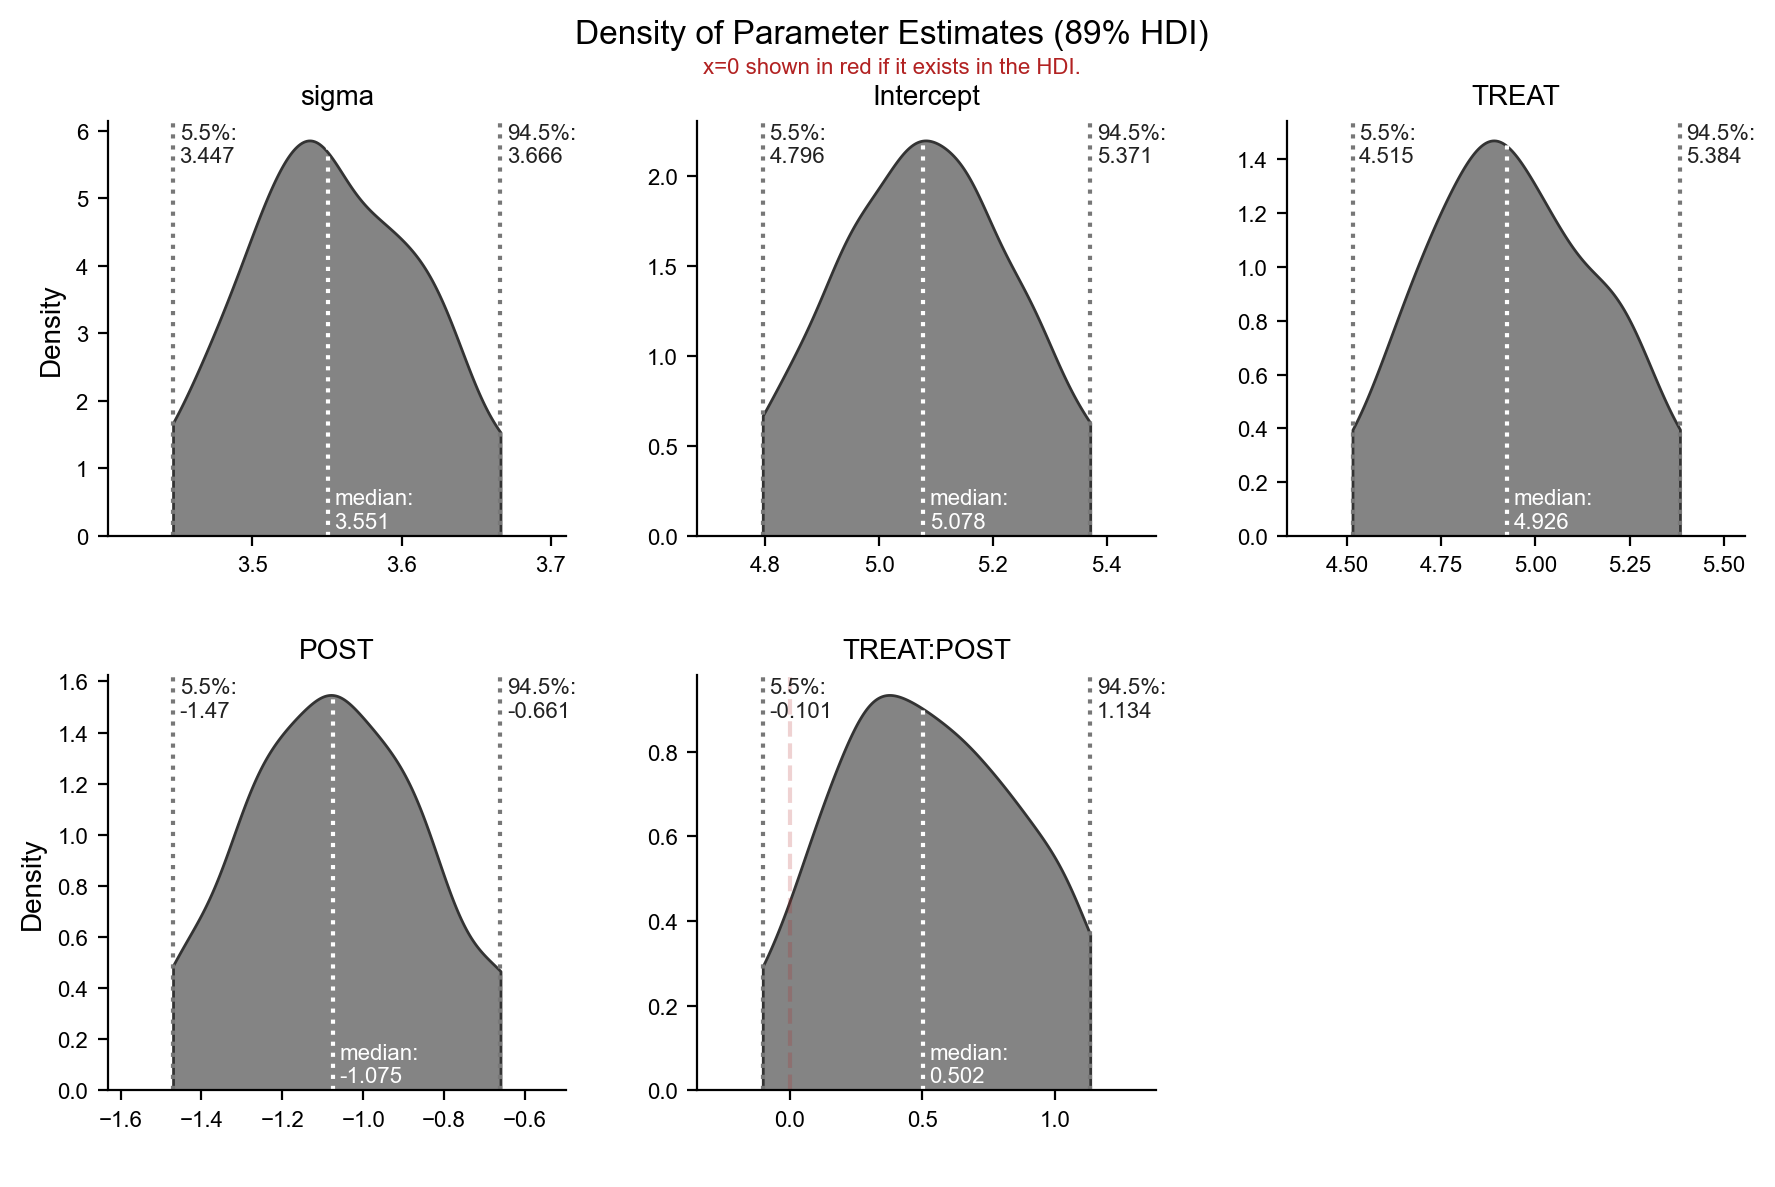

In [9]:
model._plot_hdi_density(interval=0.89)

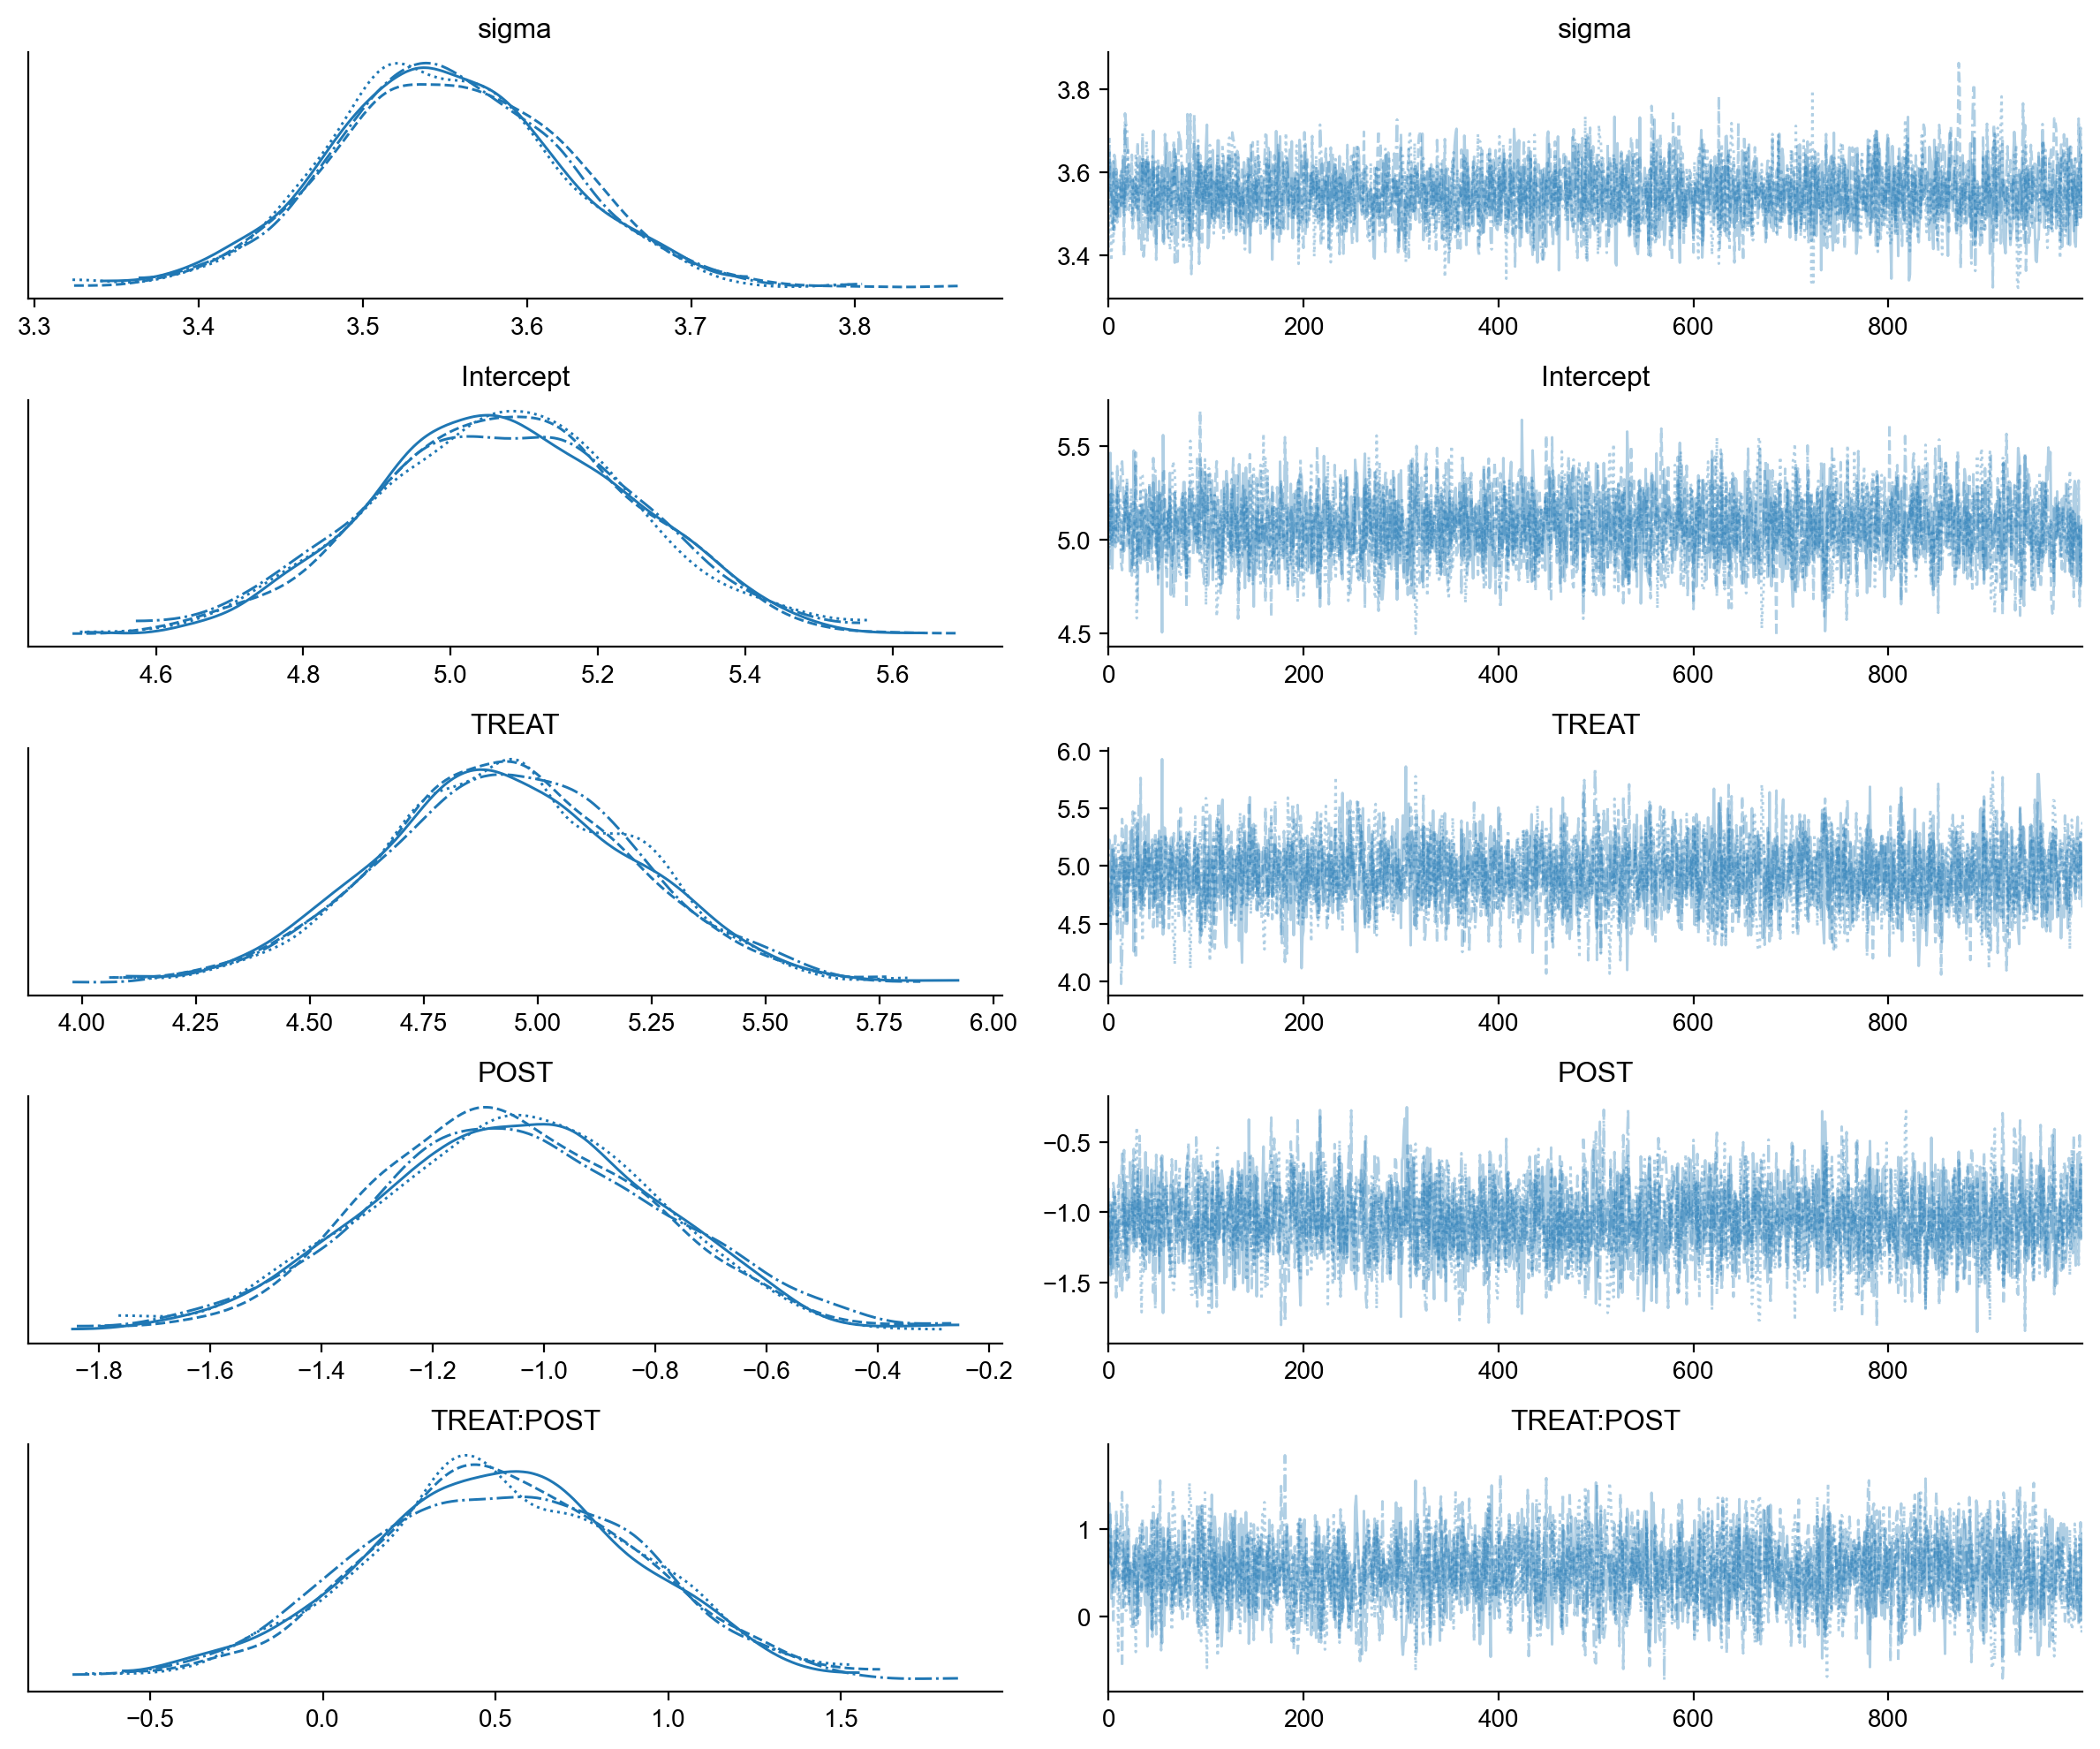

In [10]:
model.plot_trace()

#### Plot effects for DiD regression

First, plot with split point at midline (along x axis).

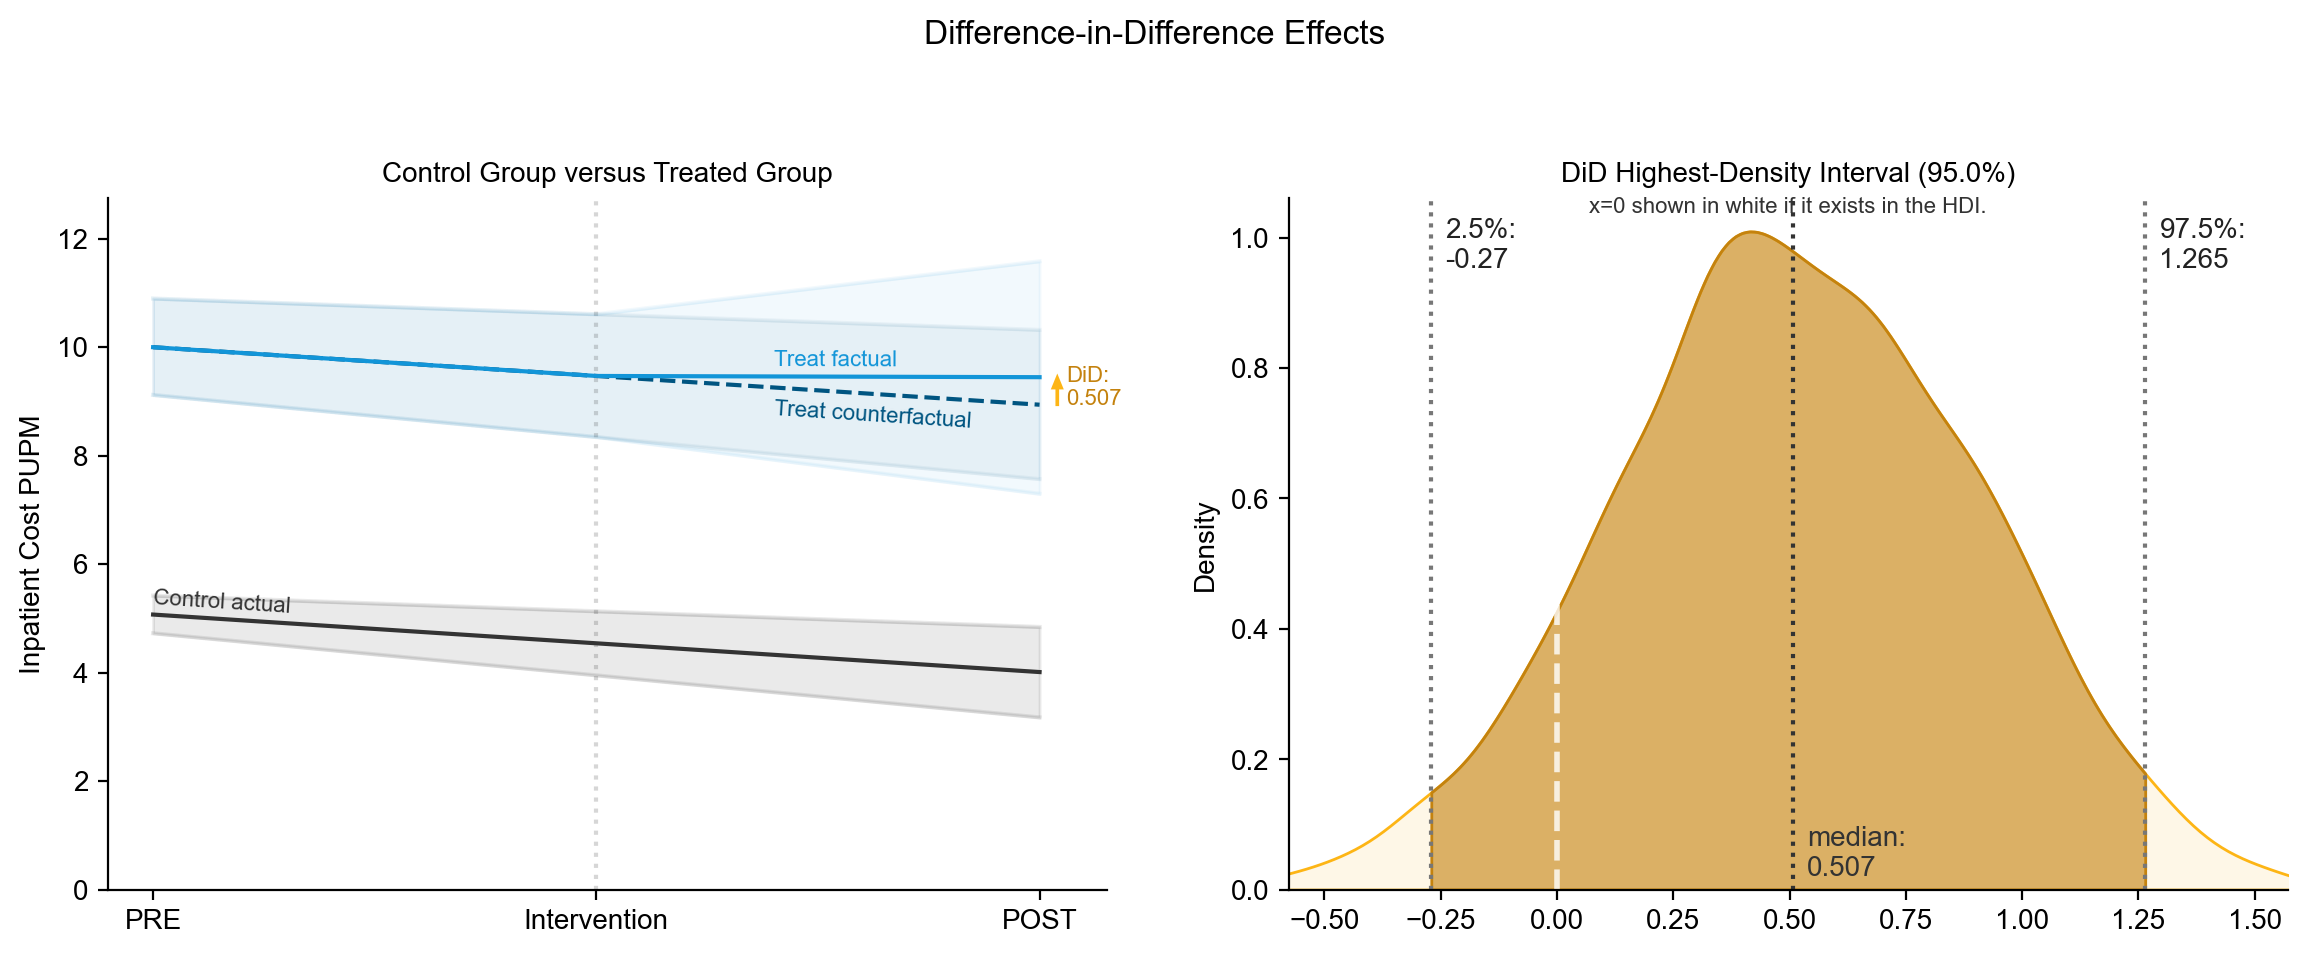

In [11]:
model.plot_effects(model, line_type = 'single', split_point=0.5, figsize=(12,5), hdi=0.95, 
                   suptitle_fontsize=12, title_fontsize=10, label_fontsize=8, tick_fontsize=10, 
                   show_did=True, y_label='Inpatient Cost PUPM', y_pad=(0.2, 0.35, 0.2), labels_above_line=(True, False, True))

Next, plot with no split (more to the point, the split point is at $x=0$).  Also, change the HDI to 89%, and leave out the y_label specification.

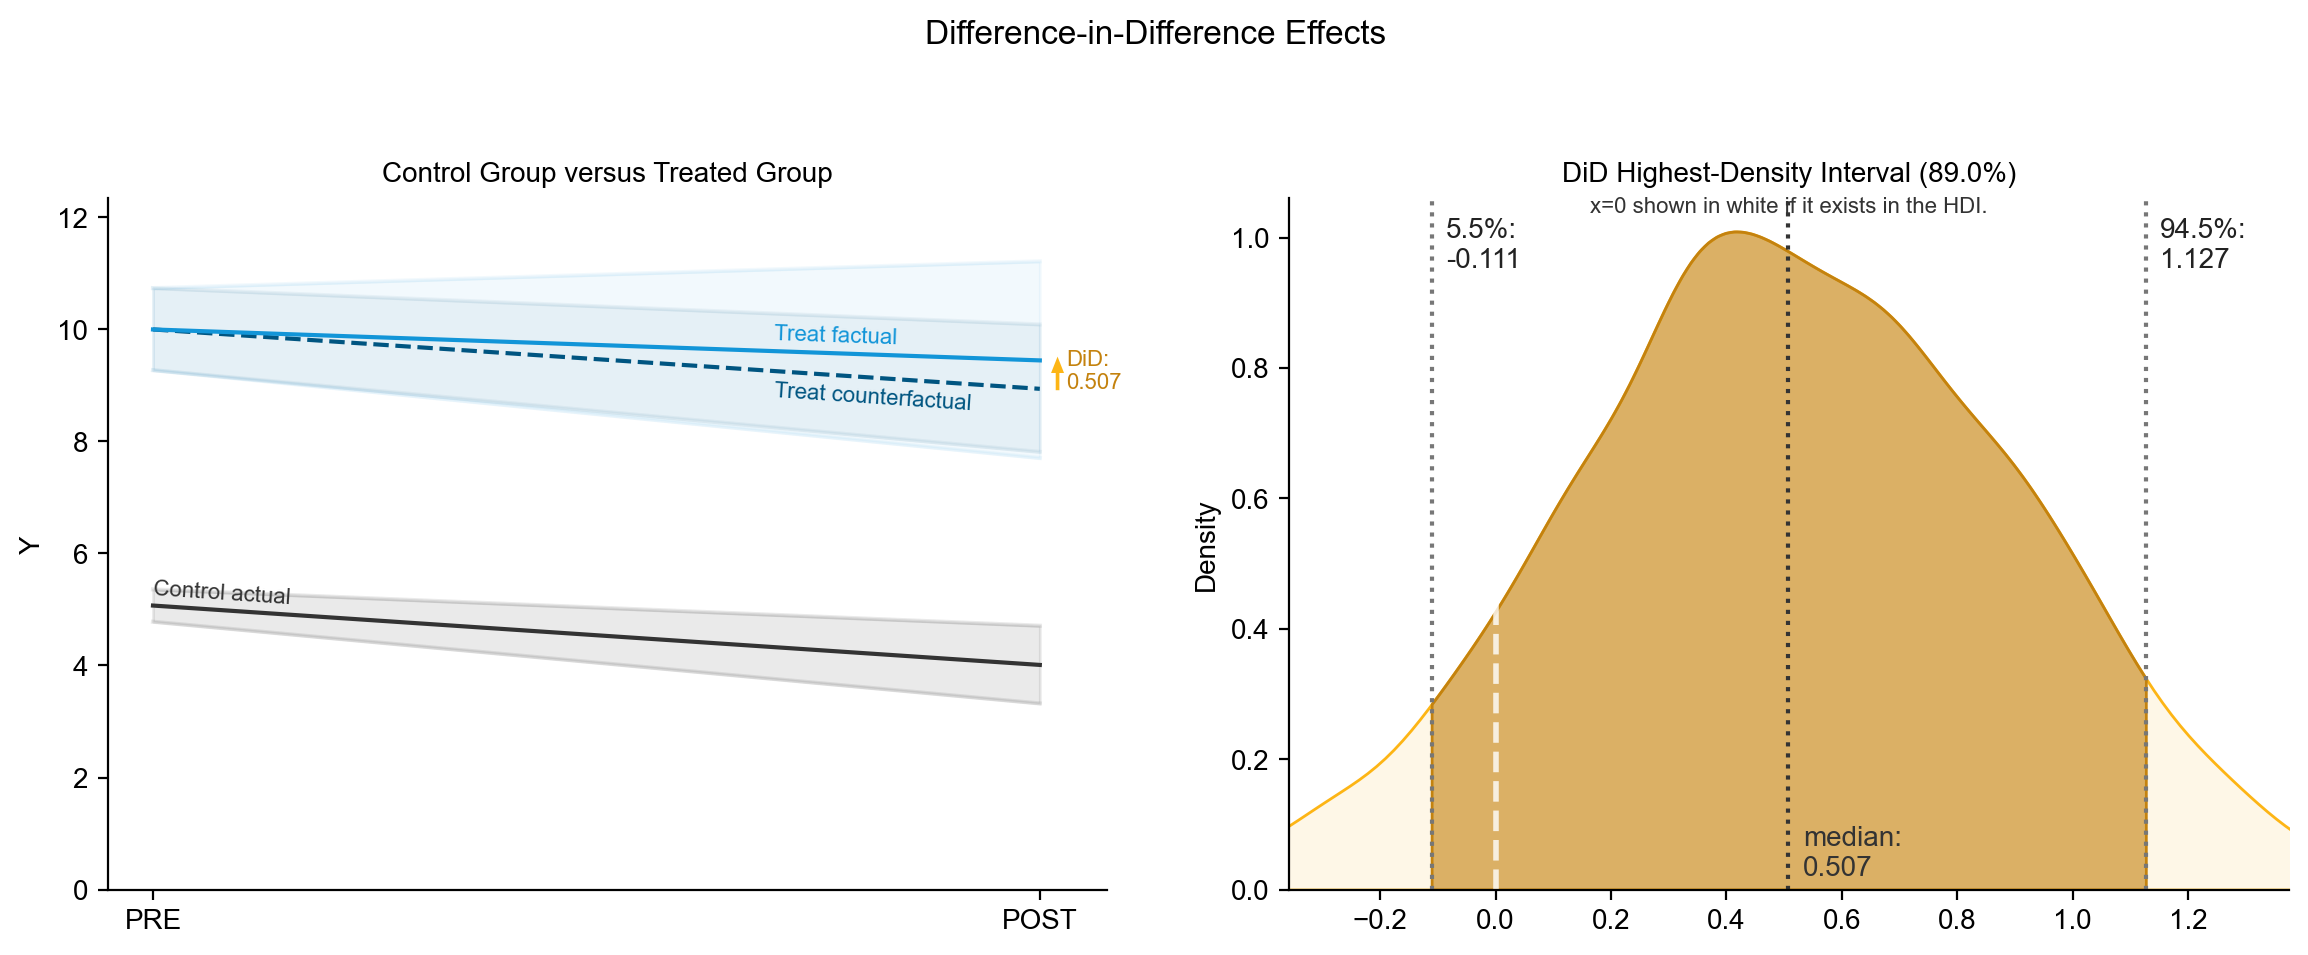

In [12]:
model.plot_effects(model, line_type = 'single', figsize=(12,5), hdi=0.89, 
                   suptitle_fontsize=12, title_fontsize=10, label_fontsize=8, tick_fontsize=10, 
                   show_intervals=False, show_did=True, y_pad=(0.2,0.3,0.2), labels_above_line=(True,False,True))

### Run DiD on treat and matched control

In [13]:
model.match_control_nn(match_features=['Female', 'Risk'])

model.fit(reg_formula = 'Y ~ TREAT + POST + TREAT * POST')



Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, TREAT, POST, TREAT:POST]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


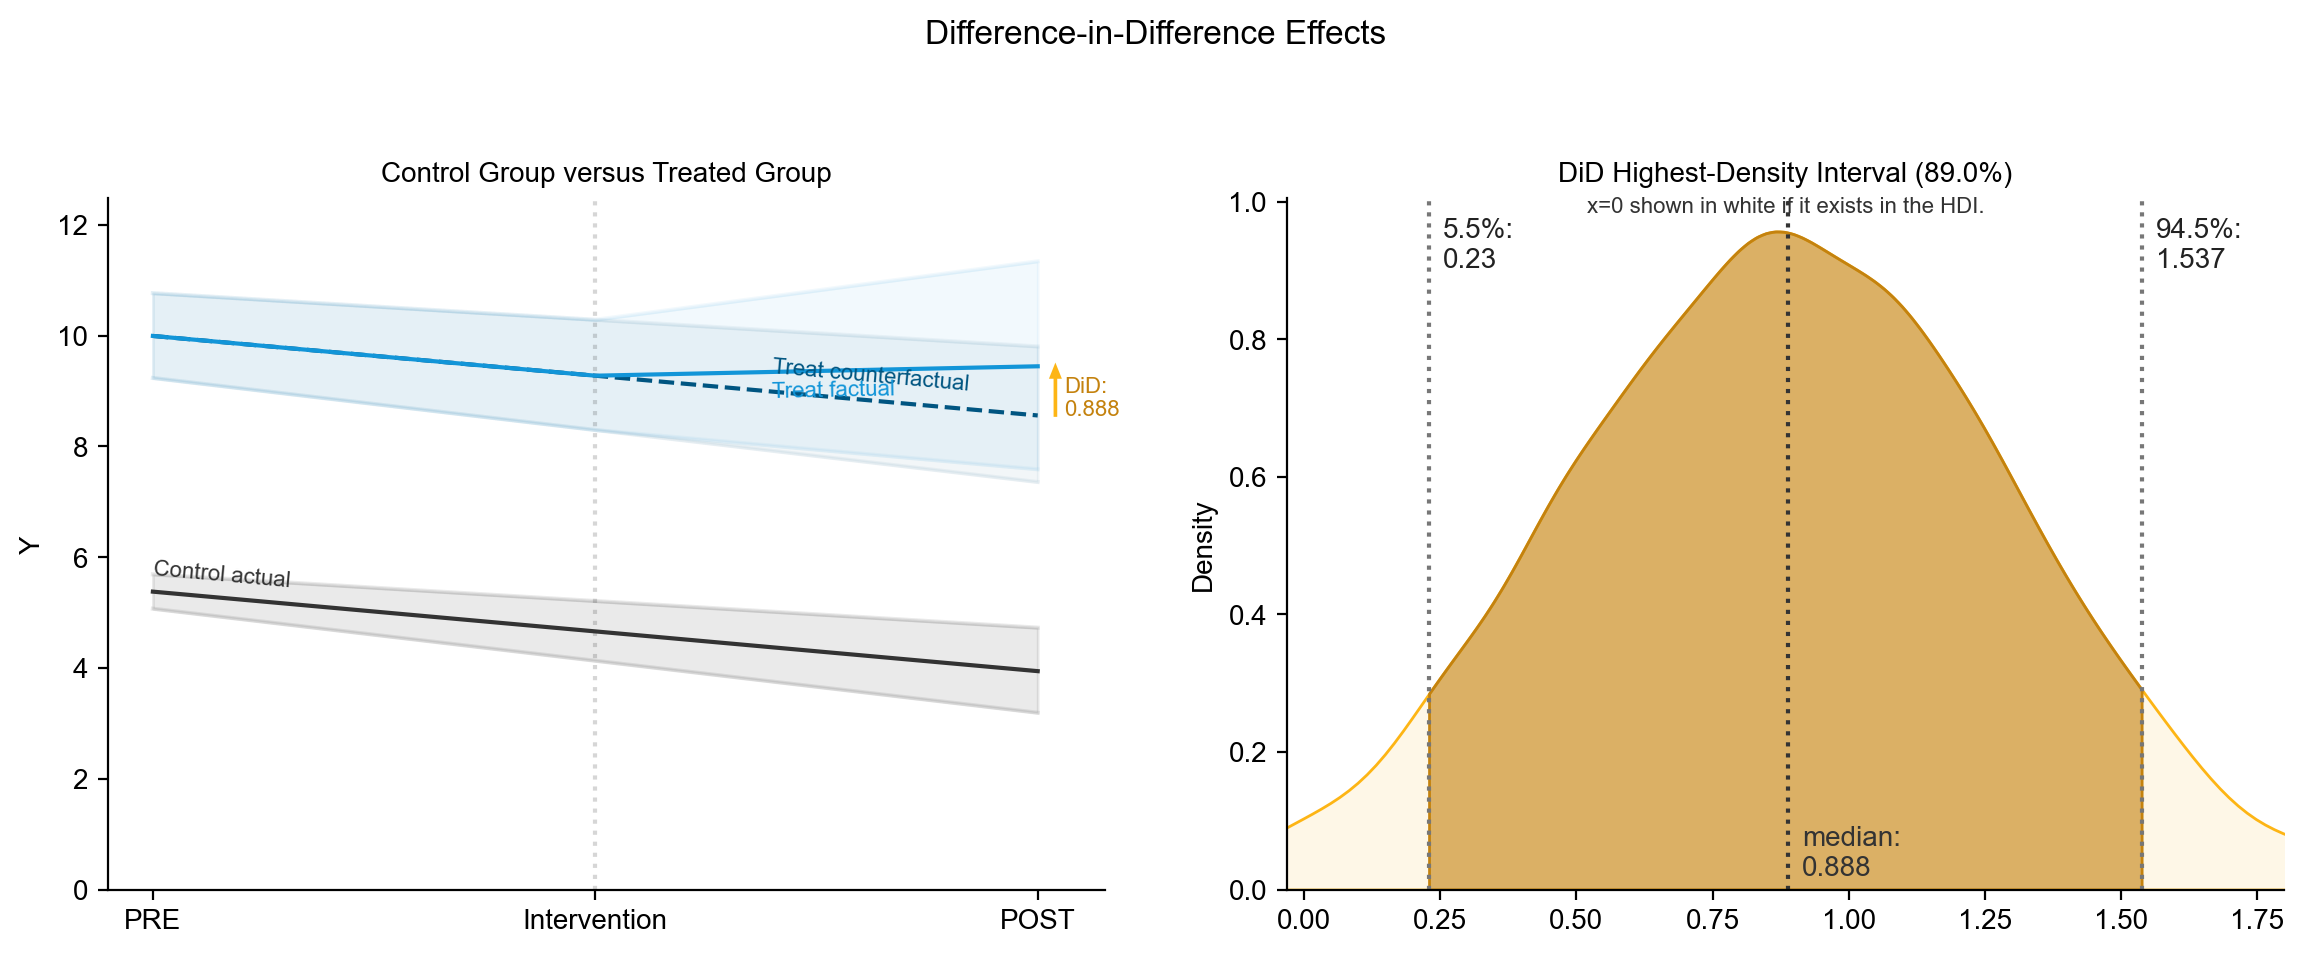

In [14]:
model.plot_effects(model, line_type = 'single', split_point=0.5, figsize=(12,5), hdi=0.89, 
                   suptitle_fontsize=12, title_fontsize=10, label_fontsize=8, tick_fontsize=10, 
                   show_did=True, y_pad=(0.3, 0.3, 0.3), labels_above_line=(False, True, True))

In [15]:
model.fit(reg_formula = 'Compliance ~ TREAT + POST + TREAT * POST')

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, TREAT, POST, TREAT:POST]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


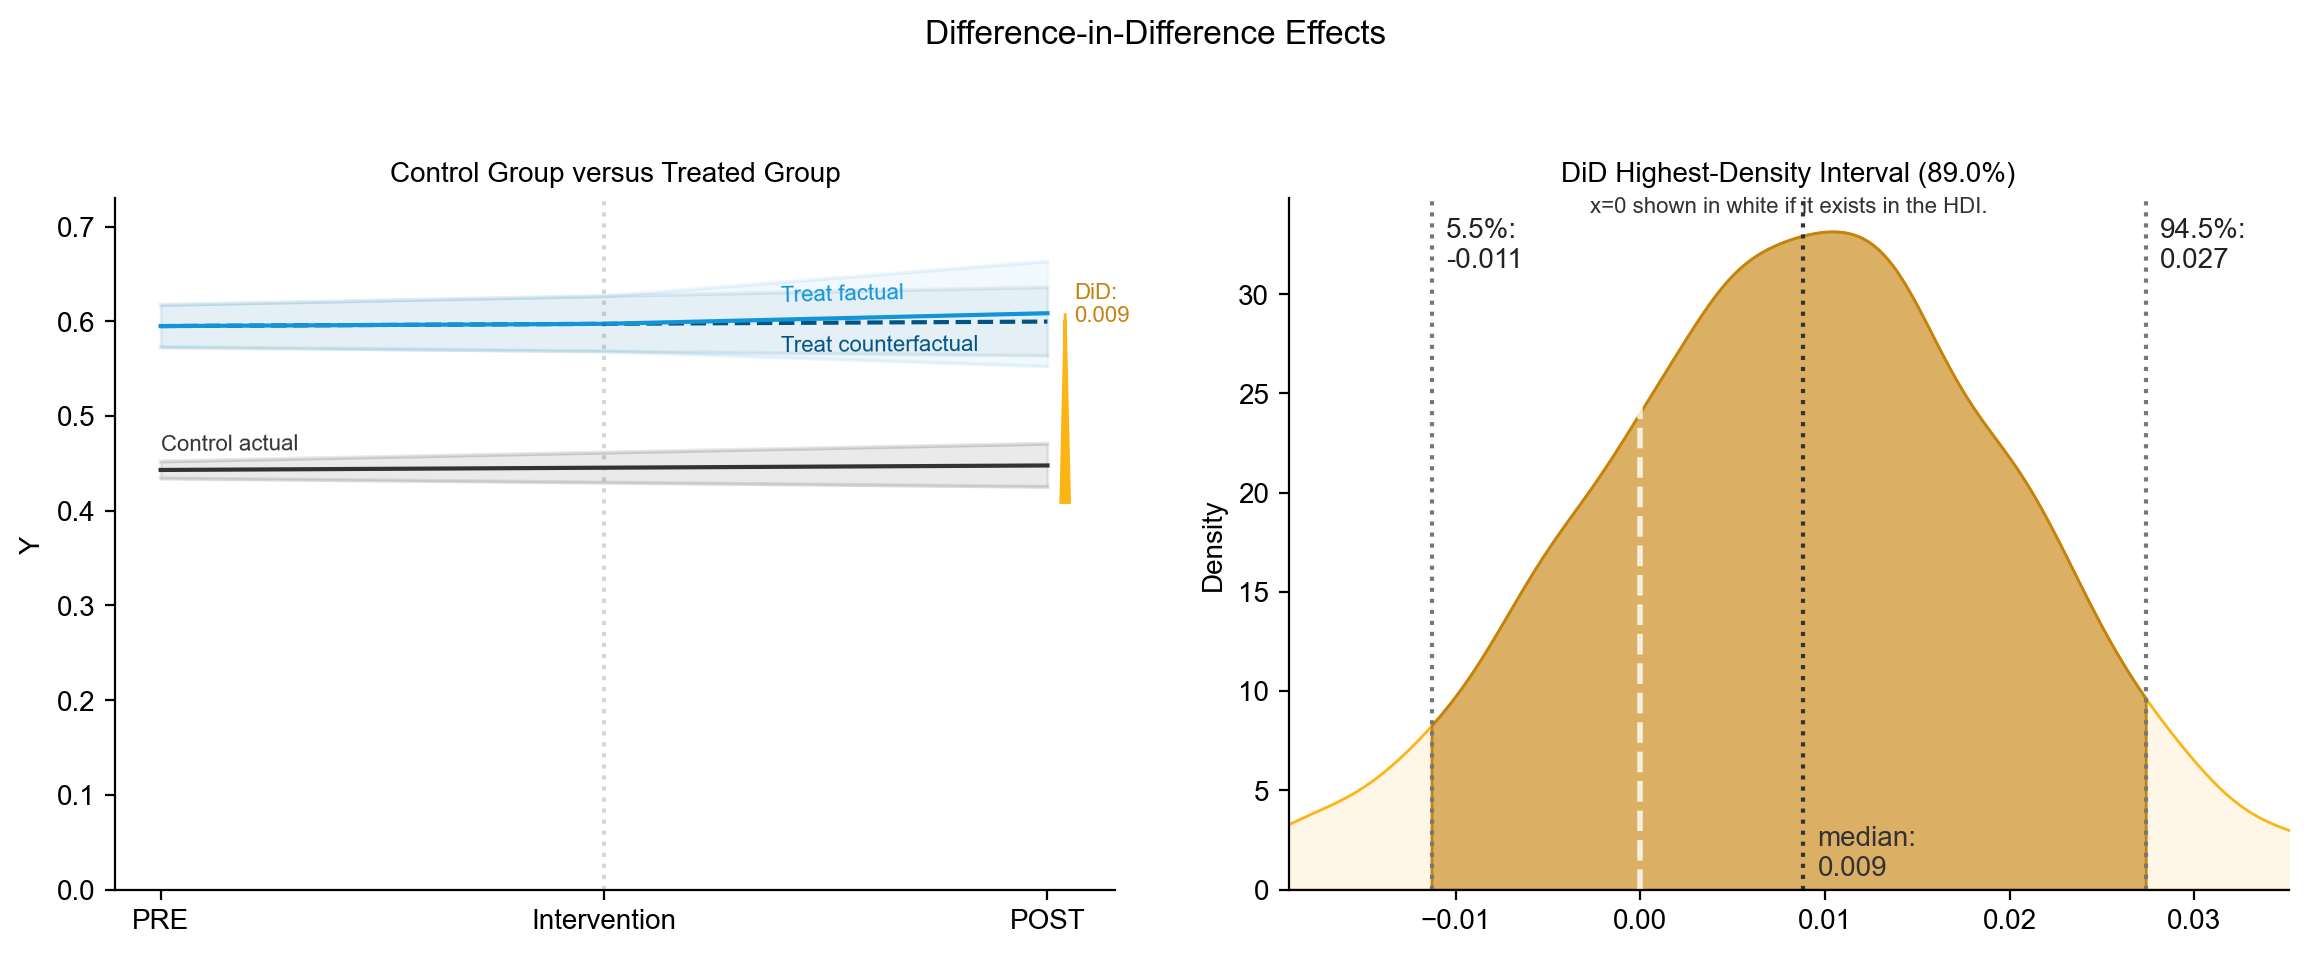

In [16]:
model.plot_effects(model, line_type = 'single', split_point=0.5, figsize=(12,5), hdi=0.89, 
                   suptitle_fontsize=12, title_fontsize=10, label_fontsize=8, tick_fontsize=10, 
                   show_did=True, labels_above_line=(True, False, True))

#### scratch space


In [17]:
# Rename "index" to "observation"
idx_treat = pd.Index.rename(model.data_treat.index, name='observation')
model.data_treat.index = idx_treat

idx_control = pd.Index.rename(model.data_control.index, name='observation')
model.data_control.index = idx_control

idx_matched_control = pd.Index.rename(model.data_matched_control.index, name='observation')
model.data_matched_control.index = idx_matched_control

idx_combined = pd.Index.rename(model.data_combined.index, name='observation')
model.data_combined.index = idx_combined

# Create xarrays
arr_treat   = xr.Dataset.from_dataframe(model.data_treat)
arr_control = xr.Dataset.from_dataframe(model.data_control)
arr_matched_control = xr.Dataset.from_dataframe(model.data_matched_control)
arr_combined = xr.Dataset.from_dataframe(model.data_combined)

# Set attributes
attr_dict = {'bistro_version': __version__,
             'Treat group variable':'TREAT',
             'Post intervention variable':'POST',
             'Outcome variable':'Y'
            }
arr_list = [arr_treat, arr_control, arr_matched_control, arr_combined]

for k,v in attr_dict.items():
    for arr in arr_list:
        arr.attrs[k] = v
    


AttributeError: 'Dataset' object has no attribute 'index'

In [ ]:
if isinstance(arr_control, xr.core.dataset.Dataset):
    print('yup')
else:
    print('nope')

In [ ]:
temp_treat_vars = sorted(list(arr_treat.keys()))
temp_treat_vars.remove('TREAT')
temp_treat_vars

In [ ]:
list(arr_treat.keys())

In [ ]:
model.plot_effects()

#### Match summaries

TODO: we need to use some metadata for TREAT and POST to get the right data for summarization.

In [23]:
def summarize_match():
    tbl_control_pre = model.data_control.loc[model.data_control['POST']==0].groupby('TREAT').mean().T
    tbl_control_pre.columns = 'TREAT'

tbl_control_pre.head()

SyntaxError: expected ':' (1581509513.py, line 1)

In [ ]:
import sys
from IPython.display import HTML, IFrame, display
display(HTML('<h3>Versions used in this notebook</h3>'))
pyver_dict = {}
pyver_dict['python'], pyver_dict['GCC'] = sys.version.split('\n')
modules_dict = {m.__name__: m.__version__ for m in globals().values() if getattr(m, '__version__', None)}
pyver_dict.update(modules_dict)
modules_df = pd.DataFrame(pyver_dict, index=[0]).T
modules_df.columns = ['Version']
modules_df

In [22]:
model.data_match_features

['Female', 'Risk']